# Short guide to the extreme-H python implementation.

# Dependencies

In [1]:
# Libraries
import pandas as pd 
import numpy as np
from scipy import stats
from scipy.stats import weibull_min,gamma, gengamma, invgamma,halfnorm,halfgennorm,rayleigh,erlang
import matplotlib.pyplot as plt
from scipy.optimize import minimize
from scipy.stats import genextreme
from scipy import integrate
from pynverse import inversefunc
import scipy.stats as stats
from scipy.stats import uniform
from scipy.integrate import quad
from scipy.optimize import root_scalar

/home/tiago/.local/lib/python3.10/site-packages/matplotlib/projections/__init__.py:63: UserWarning: Unable to import Axes3D. This may be due to multiple versions of Matplotlib being installed (e.g. as a system package and as a pip package). As a result, the 3D projection is not available.
  warnings.warn("Unable to import Axes3D. This may be due to multiple versions of "


# Auxiliar functions

In [2]:
def H_teta(a1, a2, a3, a4, a5, a6):
    return quad(lambda x: (x**a6)*np.exp(-a1*x - (a2*x**a3 + a4)**a5), 0, np.inf)[0]

def pdf_HG(y, par):
    t1, t2, t3, t4, t5, t6 = par
    H_val = H_teta(t1, t2, t3, t4, t5, t6)
    y = np.array(y)
    pdfh = 1 / H_val * y**t6 * np.exp(-t1 * y - (t2 * y**t3 + t4)**t5)
    return pdfh

def NumIntH(a1, a2, a3, a4, a5, a6):
    return quad(lambda x: (x**a6)*np.exp(-a1*x - (a2*x**a3 + a4)**a5), 0, np.inf)[0]

def NumIntH_distribution(a1, a2, a3, a4, a5, a6, y):
    return quad(lambda x: (x**a6)*np.exp(-a1*x - (a2*x**a3 + a4)**a5), 0, y)[0]

def distribution_extreme_H(x, par):
    t1, t2, t3, t4, t5, t6 = par
    c_theta = NumIntH(t1, t2, t3, t4, t5, t6)
   
    cdf_vec = [0.]*len(x)

    if(c_theta==0):
        print('c_theta == 0', t6)
    
    for index, val in enumerate(x):
        if(c_theta==0):
            print('c_theta == 0', t6, NumIntH_distribution(t1, t2, t3, t4, t5, t6, val))
            cdf_vec[index] = 0
        else:
            cdf_vec[index] = (1./c_theta) * NumIntH_distribution(t1, t2, t3, t4, t5, t6, val)

    return cdf_vec

def ecdf(data):
    x = np.sort(data)
    y = np.arange(1, len(data) + 1) / len(data)
    return x, y
    
# cost/loss function
def ecdf_error(params, data):
    x_empirical, y_empirical = ecdf(data)
    y_theoretical = distribution_extreme_H(x_empirical, params)
    error = np.sum((y_empirical - y_theoretical) ** 2)
    return error

In [3]:
#density function
#y: data set
def dg(y, theta1, theta2, theta3, theta4, theta5, theta6):
    # print('DG theta1=', theta1, type(theta1))
    # print('DG y=', y, type(y))
    c_theta = NumIntH(theta1, theta2, theta3, theta4, theta5, theta6)
    if(c_theta==0):
        print('c_theta == 0', theta6, (y**theta6)*np.exp(-theta1*y-((theta2*y**theta3)+theta4)**theta5) )
        return y*0
    return (1./c_theta)*(y**theta6)*np.exp(-theta1*y-((theta2*y**theta3)+theta4)**theta5)

#log-likelihood function
#x0: data set
def llf(x, t1, t2, t3, t4, t5, t6):

    # print('llf pre-filter x=', x)

    x0=x[dg(x, t1, t2, t3, t4, t5, t6)>0]

    # print('llf pos-filter x0=', x0, 'x<=0: ', x[dg(x, t1, t2, t3, t4, t5, t6)<=0])
    return (sum(np.log(dg(x0, t1, t2, t3, t4, t5, t6))))

def minus_llf(params, data):
    t1, t2, t3, t4, t5, t6 = params
    return -1*llf(data, t1, t2, t3, t4, t5, t6)

global global_parGlobal

def eval_fit_extreme(samples, parameters_tuple, no_print=True):
      
    logLik = llf(samples, parameters_tuple[0], parameters_tuple[1], parameters_tuple[2], parameters_tuple[3], parameters_tuple[4], parameters_tuple[5])

    k = len(parameters_tuple)
    aic = 2*k - 2*(logLik)
    n = np.log(len(samples))
    aicc = aic + 2*k*(k+1)/(n-k-1)

    bic = k*n-2*logLik
    edc = -2*logLik-k*np.log(n)

    if(no_print):
        print('AIC: ', aic, 'AICc:', aicc, 'BIC: ', bic, 'EDC:', edc,'Log-Likelihood', logLik)

    global global_parGlobal
    
    global_parGlobal = parameters_tuple

    # print('global_parGlobal', global_parGlobal)
    
    ks = stats.kstest(samples, distribution_extreme_H_ks)

    cvm = stats.cramervonmises(samples, distribution_extreme_H_ks)

    if(no_print):
        print('KS :', ks)
        print('CVM :', cvm)
    
    return aic, aicc, bic, edc, logLik

def distribution_extreme_H_ks(x):
    #print('global_parGlobal', global_parGlobal)
    t1, t2, t3, t4, t5, t6 = global_parGlobal
    c_theta = NumIntH(t1, t2, t3, t4, t5, t6)
   
    cdf_vec = [0.]*len(x)
    
    for index, val in enumerate(x):
        if val==0:
            cdf_vec[index] = 0
        elif np.isnan(val):
            cdf_vec[index] = 0
        else:
            # print('val =', val)
            cdf_vec[index] = (1./c_theta) * NumIntH_distribution(t1, t2, t3, t4, t5, t6, val)

    return cdf_vec


In [4]:
# Generator and PPF

def _distribution_extreme_H_priv(x, theta1, theta2, theta3, theta4, theta5, theta6):
    
    if isinstance(x, float):      
        
        # print(x)
        
        if x==0:
            return 0
            
        c_theta = NumIntH(theta1, theta2, theta3, theta4, theta5, theta6)
        return (1./c_theta)*NumIntH_distribution(theta1, theta2, theta3, theta4, theta5, theta6, x)
    else:
        return distribution_extreme_H(x, [theta1, theta2, theta3, theta4, theta5, theta6])

def inversefunc2(theta1, theta2, theta3, theta4, theta5, theta6,target):
    sol = root_scalar(lambda x, *args: _distribution_extreme_H_priv(x, *args) - target,
                      bracket=(0,1000),# coloquei um limite superior alto, mas da pra estimar a partir dos parametros, eventualmente.
                      args=(theta1, theta2, theta3, theta4, theta5, theta6))
    return sol.root

def extreme_H_rvs2(theta_vec, size=1):
    theta1 = theta_vec[0]
    theta2 = theta_vec[1]
    theta3 = theta_vec[2]
    theta4 = theta_vec[3]
    theta5 = theta_vec[4]
    theta6 = theta_vec[5]

    y_values = uniform.rvs(loc=0.0001,scale=0.9998,size=size)

    inv_vals = [inversefunc2(theta1, theta2, theta3, theta4, theta5, theta6,y) for y in y_values]

    return np.array(inv_vals)
    
def extreme_H_ppf(samples, theta_vec):
    theta1 = theta_vec[0]
    theta2 = theta_vec[1]
    theta3 = theta_vec[2]
    theta4 = theta_vec[3]
    theta5 = theta_vec[4]
    theta6 = theta_vec[5]
    my_F_distribution = (lambda x: _distribution_extreme_H_priv(x, theta1, theta2, theta3, theta4, theta5, theta6))
    
    y_values = samples
    
    return inversefunc(my_F_distribution, y_values=y_values)

## All-in-one

In [5]:
def estimate_extremeH(samples, particular_model_from_table1=4, initial_guess=[], do_metrics=True):

    match particular_model_from_table1:
        case 1:
            print("Frechet")

            base_distribution = stats.invweibull
            
            particular_parameters = base_distribution.fit(samples, floc=0)

            bounds = [(0, 10), (0, 10), (-10, 10), (0, 10), (-10, 10), (-10, 50)]
        
            sigma = particular_parameters[2]
            shape = particular_parameters[0]
            
            # Frechet: from Table 1
            initial_params = [0, 1/sigma, 1, 0, -shape, -shape-1]
                     
            print('shape =', shape, ' scale=', sigma)
            print('initial guess ', initial_params)

        case 2:
            print("Weibull")
 
            base_distribution = stats.weibull_min

            particular_parameters = base_distribution.fit(samples, floc=0)

            bounds = [(0, 10), (0, 10), (-10, 10), (0, 10), (-10, 10), (0, 50)]        
            
            sigma = particular_parameters[2]
            shape = particular_parameters[0]
            
            # Weibull: from Table 1
            initial_params = [0, 1/sigma, 1, 0, shape, shape-1]                     
            
            print('shape =', shape, ' scale=', sigma)
            print('initial guess ', initial_params)
            
        case 3:
            print("Gamma")

            bounds = [(0, 10), (0, 10), (-10, 10), (0, 10), (-10, 10), (-0.9, 50)]
        
            shape, loc, scale = gamma.fit(samples, floc=0)  
            
            alpha = shape
            beta =  1 / scale  
            
            initial_params = [beta, 0, 1, 0, 1, shape-1]
            print('initial guess ', initial_params)
            
        case _:  # The wildcard '_' acts as the default case
            print("Half-normal")

            bounds = [(0, 10), (0, 10), (-10, 10), (0, 10), (-10, 10), (-0.9, 50)]
        
            _, scale = halfnorm.fit(samples, floc=0)    
            
            initial_params = [1, 0.5*scale**2, 2, 0, 1, 0]
            print('initial guess ', initial_params)

    data = np.array(samples)

    if len(initial_guess) == 0:
        # LSE ECDF vs CDF: Algorithm 1
        result = minimize(ecdf_error, initial_params, args=(data,), bounds=bounds, method='Nelder-Mead')
        optimal_params = result.x
        print("[Algorithm 1] ECDF optimized parameters:", optimal_params)
    else:
        optimal_params = initial_guess
        print("Skipping Algorithm 1. Got a guess from user input:", optimal_params)    
        
    # MLE: Algorithm 2 (using n-tuple from Algorithm 1)
    if (particular_model_from_table1 == 1) | (particular_model_from_table1 == 2) | (particular_model_from_table1 == 4):
        result = minimize(minus_llf, optimal_params, args=(np.asarray(data),), bounds=bounds, method='Nelder-Mead')
    #elif (particular_model_from_table1 == 4):
    #    result = minimize(minus_llf, optimal_params, args=(np.asarray(data),), bounds=bounds, method='SLSQP')
    else:
        result = minimize(minus_llf, optimal_params, args=(np.asarray(data),), bounds=bounds, method='L-BFGS-B')
    
    optimal_params_llf = result.x
    
    print("[Algorithm 2] MLE Optimized Parameters:", optimal_params_llf)

    if(do_metrics):
        aic, aicc, bic, edc, logLik = eval_fit_extreme(data, initial_params)
        aic, aicc, bic, edc, logLik = eval_fit_extreme(data, optimal_params_llf)
        return optimal_params_llf, aic, aicc, bic, edc, logLik

    return optimal_params_llf, -1, -1, -1, -1, -1

## CI

In [6]:
def jackknifed_estimate_extremeH(samples, particular_model_from_table1=4, initial_guess=[]):
    
    sample_count=len(samples)

    my_samples = []

    samples = np.array(samples)
    
    idx = np.arange(sample_count)

    # print(idx, range(sample_count))
    
    for i in range(sample_count):
        
        print(i, 'of', sample_count)
        
        jk_sample = samples[idx!=i]
           
        optimal_params_llf, _, _, _, _, _ = estimate_extremeH(jk_sample, particular_model_from_table1, initial_guess, do_metrics=False)
        
        my_samples.append(optimal_params_llf)
        
#     if(display):
#         plot_histogram(my_samples, 'Bootstrap: R', str(runs)+'-run simulation')

    # print(my_samples)

    print('Sample mean', np.mean(my_samples, axis=0), '\nSample median', np.median(my_samples, axis=0))
    print('Q2.5%: ', np.percentile(my_samples, 2.5, axis=0))
    print('Q97.5%: ', np.percentile(my_samples, 97.5, axis=0))

    eval_fit_extreme(samples, np.mean(my_samples, axis=0))
    
    return np.mean(my_samples, axis=0), [np.percentile(my_samples, 2.5, axis=0), np.percentile(my_samples, 97.5, axis=0)], my_samples

## Bootstrap Based Goodness-Of-Fit Test

In [7]:
def eval_ks_cvm(samples, parameters_tuple, no_print=True):
      
    global global_parGlobal
    
    global_parGlobal = parameters_tuple

    # print('global_parGlobal', global_parGlobal)
    
    ks = stats.kstest(samples, distribution_extreme_H_ks)

    cvm = stats.cramervonmises(samples, distribution_extreme_H_ks)

    if(no_print):
        print('KS :', ks)
        print('CVM :', cvm)
    
    return ks.pvalue, ks.statistic, cvm.pvalue, cvm.statistic

In [8]:
def eval_estimated_extremeH(samples, optimal_params, particular_model_from_table1=4, initial_guess=[]):

    data = np.array(samples)

    ks_pvalue, ks_statistic, cvm_pvalue, cvm_statistic = eval_ks_cvm(data, optimal_params)

    M = 150

    n = len(samples)

    idx = np.arange(n)
    samples = np.array(samples)

    p_ks = 0
    p_cvm = 0

    for i in range(M):
        
        print(i, 'of', M, 'params = ',optimal_params)

        if( particular_model_from_table1 != 3 ):
            new_sample = extreme_H_rvs2(optimal_params, n)
            all_zeros = all(x == 0.0 for x in new_sample)
            if all_zeros:
                print('all zeros! resampling...')
                new_sample = extreme_H_rvs2(optimal_params, n)
        else:
            new_sample = samples[idx!=i]
            #new_sample = np.random.choice(samples, n)

        optimal_params_from_sample, _, _, _, _, _ = estimate_extremeH(new_sample, particular_model_from_table1, initial_guess, False)
        ks_pvalue_from_sample, ks_statistic_from_sample, cvm_pvalue_from_sample, cvm_statistic_from_sample = eval_ks_cvm(new_sample, optimal_params_from_sample, False)

        if(ks_statistic_from_sample > ks_statistic):
            p_ks = p_ks + 1
            
        if(cvm_statistic_from_sample > cvm_statistic):
            p_cvm = p_cvm + 1

        print('Partial ks: ', p_ks/(i+1), ' Partial cvm: ', p_cvm/(i+1))

    print('ks: ', p_ks/M)

    print('cvm: ', p_cvm/M)  

    return p_ks/M, p_cvm/M
    

In [22]:
def eval_estimated_extremeH_state(samples, optimal_params, state, particular_model_from_table1=4, initial_guess=[]):

    data = np.array(samples)

    ks_pvalue, ks_statistic, cvm_pvalue, cvm_statistic = eval_ks_cvm(data, optimal_params)

    M = 1000

    n = len(samples)

    idx = np.arange(n)
    samples = np.array(samples)

    p_ks = state.p_ks
    p_cvm = state.p_cvm

    last_salved_step = state.last

    for i in range(last_salved_step, M):
        
        print(i, 'of', M, 'params = ',optimal_params)

        if( particular_model_from_table1 != 3 ):
            new_sample = extreme_H_rvs2(optimal_params, n)
            all_zeros = all(x == 0.0 for x in new_sample)
            if all_zeros:
                print('all zeros! resampling...')
                new_sample = extreme_H_rvs2(optimal_params, n)
        else:
            #new_sample = samples[idx!=i]
            new_sample = np.random.choice(samples, n)

        optimal_params_from_sample, _, _, _, _, _ = estimate_extremeH(new_sample, particular_model_from_table1, initial_guess, False)
        ks_pvalue_from_sample, ks_statistic_from_sample, cvm_pvalue_from_sample, cvm_statistic_from_sample = eval_ks_cvm(new_sample, optimal_params_from_sample, False)

        if(ks_statistic_from_sample > ks_statistic):
            p_ks = p_ks + 1
            
        if(cvm_statistic_from_sample > cvm_statistic):
            p_cvm = p_cvm + 1

        print('Partial ks: ', p_ks/(i+1), ' Partial cvm: ', p_cvm/(i+1))

        state.p_ks = p_ks
        state.p_cvm = p_cvm
        state.last = i+1

    print('ks: ', p_ks/M)

    print('cvm: ', p_cvm/M)  

    return p_ks/M, p_cvm/M, state
    

# Examples

In [11]:
def plot_pdf(parameters_tuple, atitle, xlabel):    
    
    fig, ax = plt.subplots(1, 1)
    
    x=np.arange(1, 100)

    pdf_values = pdf_HG(x, parameters_tuple)

    ax.plot(x, pdf_values, 'r-', lw=5, alpha=0.6)
    ax.set_xlim([x[0], x[-1]])
       
    plt.title(atitle,fontsize=14)
    plt.xlabel(xlabel, fontsize=14)
    plt.ylabel('pdf', fontsize=14)
    plt.show()
        
    return

def plot_cdf(parameters_tuple, atitle, xlabel):    
    
    fig, ax = plt.subplots(1, 1)
    
    x=np.arange(1, 100)

    pdf_values = distribution_extreme_H(x, parameters_tuple)

    ax.plot(x, pdf_values, 'r-', lw=5, alpha=0.6)
    ax.set_xlim([x[0], x[-1]])
       
    plt.title(atitle,fontsize=14)
    plt.xlabel(xlabel, fontsize=14)
    plt.ylabel('cdf', fontsize=14)
    plt.show()
        
    return

## Plotting PDF and CDF from a parameter tuple

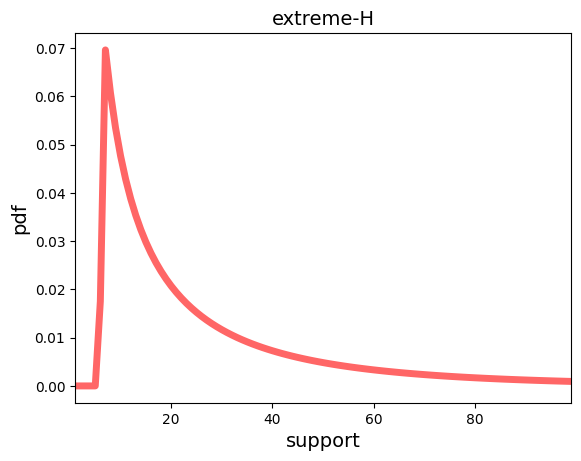

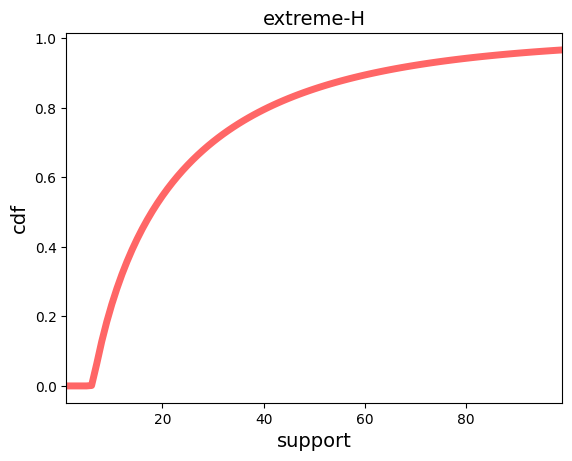

In [12]:
parameter_tuple = [2.10280344e-02,  7.67695842e-04,  3.97317286e+00,  7.11604099e-03, -9.50968970e+00, -8.99142058e-01]

plot_pdf( parameter_tuple, 'extreme-H', 'support')

plot_cdf( parameter_tuple, 'extreme-H', 'support')

## Taking a parameter tuple to generate samples

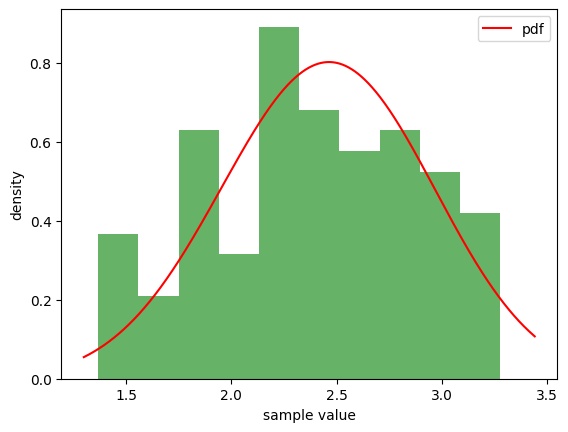

In [13]:
#parameters_tuple = [2.10280344e-02,  7.67695842e-04,  3.97317286e+00,  7.11604099e-03, -9.50968970e+00, -8.99142058e-01]
parameters_tuple = [2.55584476e-05, 6.43480671e-01, 6.27314530e-01, 1.83895256e-02, 5.40854354e+00, 7.15147852e+00]

sample = extreme_H_rvs2(parameters_tuple, 100)

# print(sample)

fig, ax = plt.subplots(1, 1)

plt.hist(sample, bins=10, density=True, alpha=0.6, color='g')

x = np.linspace(0.95*min(sample), 1.05*max(sample), 1000)
pdf_values = pdf_HG(x, parameters_tuple)

plt.plot(x, pdf_values, 'r-', label='pdf')
plt.xlabel('sample value')
plt.ylabel('density')
plt.legend()
plt.show()

## Trying Algorithms 1 and 2 from a sample.
### Remark: we need a initial guess to start both algorithms.
#### For Algorithm 1, we can take a particular case (from Table 1) that fits data  

In [14]:
X = sample
bounds = [(0, 10), (0, 10), (-10, 10), (0, 10), (-10, 10), (-0.9, 50)]

# we need an initial guess: it is recommended to come from particular cases (Table 1)
initial_params = [0.2, 0.1, 3, 0.1, -9 , -0.9]

# LSE ECDF vs CDF: Algorithm 1
result = minimize(ecdf_error, initial_params, args=(X,), bounds=bounds, method='Nelder-Mead')
optimal_params = result.x

print("[Algorithm 1] ECDF optimized parameters:", optimal_params)

# MLE: Algorithm 2 (using n-tuple from Algorithm 1)
result = minimize(minus_llf, optimal_params, args=(np.asarray(X),), bounds=bounds, method='Nelder-Mead')
optimal_params_llf = result.x

print("[Algorithm 2] MLE Optimized Parameters:", optimal_params_llf)

[Algorithm 1] ECDF optimized parameters: [ 3.89665018  0.01964717  2.74409247  0.07406691 -1.14055228 -0.9       ]
[Algorithm 2] MLE Optimized Parameters: [ 9.90882768  0.03026887  1.25527318  0.28190061 -3.23609051 -0.9       ]


AIC:  153.48580538070584 AICc: 118.41024405750682 BIC:  169.1168264966344 EDC: 132.32272762585842 Log-Likelihood -70.74290269035292
KS : KstestResult(statistic=0.08517375407176814, pvalue=0.4385062294584605, statistic_location=2.3344529670468606, statistic_sign=1)
CVM : CramerVonMisesResult(statistic=0.17091081133908448, pvalue=0.33207781347342413)
AIC:  1523.1688692503544 AICc: 1488.0933079271554 BIC:  1538.799890366283 EDC: 1502.005791495507 Log-Likelihood -755.5844346251772
KS : KstestResult(statistic=0.6345591251845142, pvalue=1.3603759511132116e-39, statistic_location=3.2761955359822066, statistic_sign=1)
CVM : CramerVonMisesResult(statistic=16.85221571514149, pvalue=6.693638976429384e-10)
AIC:  165.33786963386586 AICc: 130.26230831066684 BIC:  180.9688907497944 EDC: 144.17479187901847 Log-Likelihood -76.66893481693293
KS : KstestResult(statistic=0.060772659495569537, pvalue=0.8318535286852875, statistic_location=3.2761955359822066, statistic_sign=1)
CVM : CramerVonMisesResult(sta

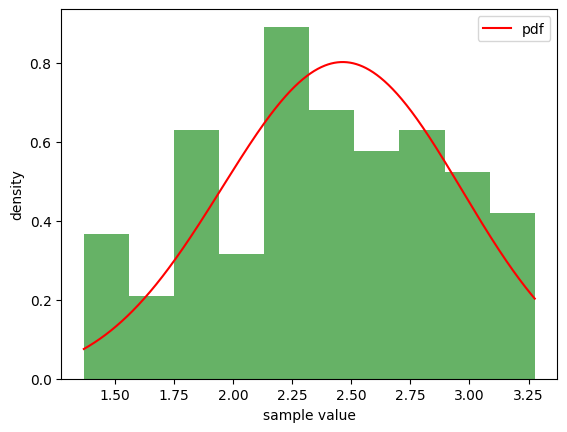

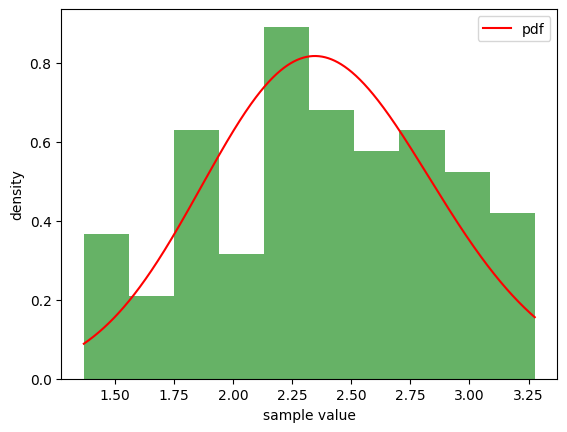

In [15]:
data = sample

generated_params = parameters_tuple

aic, aicc, bic, edc, logLik = eval_fit_extreme(data, generated_params)

aic, aicc, bic, edc, logLik = eval_fit_extreme(data, initial_params)

aic, aicc, bic, edc, logLik = eval_fit_extreme(data, optimal_params)

aic, aicc, bic, edc, logLik = eval_fit_extreme(data, optimal_params_llf)

fig, ax = plt.subplots(1, 1)

plt.hist(sample, bins=10, density=True, alpha=0.6, color='g')

x = np.linspace(min(sample), max(sample), 1000)
pdf_values = pdf_HG(x, generated_params)

plt.plot(x, pdf_values, 'r-', label='pdf')
plt.xlabel('sample value')
plt.ylabel('density')
plt.legend()
plt.show()

fig, ax = plt.subplots(1, 1)

plt.hist(sample, bins=10, density=True, alpha=0.6, color='g')

x = np.linspace(min(sample), max(sample), 1000)
pdf_values = pdf_HG(x, optimal_params_llf)

plt.plot(x, pdf_values, 'r-', label='pdf')
plt.xlabel('sample value')
plt.ylabel('density')
plt.legend()
plt.show()

# Table 3 reproduction

## Frechet

In [16]:
# Piracicaba River dataset
# P. L. Ramos, F. Louzada, E. Ramos, and S. Dey. The fréchet distribution: Estimation and application - an overview. Journal of Statistics and Management Systems, 23(3):549–578, 2020
september_flow = [29.19, 8.49, 7.37, 82.93, 44.18, 13.82, 22.28, 28.06, 6.84, 12.14, 153.78, 17.04, 13.47, 15.43, 30.36, 6.91, 22.12, 35.45, 44.66, 95.81, 6.18, 10.00, 58.39, 24.05, 17.03, 38.65, 47.17, 27.99, 11.84, 9.60, 6.72, 13.74, 14.60, 9.65, 10.39, 60.14, 15.51, 14.69, 16.44]


# Frechet
base_distribution = stats.invweibull

X = september_flow
print('X &', min(X),' & ', np.percentile(X,25), ' & ', np.median(X), ' & ', np.mean(X), ' & ', np.percentile(X,75), ' & ', max(X), ' & ', len(X))

optimal_params_llf, aic, aicc, bic, edc, logLik = estimate_extremeH(X, 1)

print(optimal_params_llf, aic, aicc, bic, edc, logLik)

X & 6.18  &  11.115  &  16.44  &  28.284871794871798  &  32.905  &  153.78  &  39
Frechet
shape = 1.5644948551004678  scale= 13.76067644260458
initial guess  [0, 0.07267084610055136, 1, 0, -1.5644948551004678, -2.5644948551004676]
[Algorithm 1] ECDF optimized parameters: [ 1.30923457e-02  3.63820093e-01  5.16540683e-01  6.02528066e-04
 -5.08883272e+00 -1.44633923e+00]
[Algorithm 2] MLE Optimized Parameters: [ 2.10280344e-02  7.67695842e-04  3.97317286e+00  7.11604099e-03
 -9.50968970e+00 -8.99142058e-01]
AIC:  333.69480197665627 AICc: 308.51825408613166 BIC:  343.67617185343414 EDC: 313.9041871671185 Log-Likelihood -160.84740098832813
KS : KstestResult(statistic=0.07841473668358723, pvalue=0.9548579573017629, statistic_location=27.99, statistic_sign=-1)
CVM : CramerVonMisesResult(statistic=0.03502502024324822, pvalue=0.9587609518455297)
AIC:  328.89213306035896 AICc: 303.71558516983436 BIC:  338.87350293713683 EDC: 309.1015182508212 Log-Likelihood -158.44606653017948
KS : KstestResult(

## p-values: ks and cvm

### Bootstrap (1000 replications)

In [20]:
class State:
    def __init__(self, p_ks, p_cvm, last):
        self.p_ks = p_ks
        self.p_cvm = p_cvm
        self.last = last

frechet_state = State(0, 0, 0) 

ks, cvm, frechet_state = eval_estimated_extremeH_state(X, optimal_params_llf, frechet_state, 1, [0, 0.07267084610055136, 1, 0, -1.5644948551004678, -2.5644948551004676])

KS : KstestResult(statistic=0.08515066054675868, pvalue=0.9171237055863223, statistic_location=17.04, statistic_sign=1)
CVM : CramerVonMisesResult(statistic=0.028689613424730736, pvalue=0.9815131307693734)
0 of 1000 params =  [ 2.10280344e-02  7.67695842e-04  3.97317286e+00  7.11604099e-03
 -9.50968970e+00 -8.99142058e-01]
Frechet
shape = 1.6969073173705347  scale= 14.351813921518282
initial guess  [0, 0.06967760350492405, 1, 0, -1.6969073173705347, -2.6969073173705347]
Skipping Algorithm 1. Got a guess from user input: [0, 0.07267084610055136, 1, 0, -1.5644948551004678, -2.5644948551004676]
[Algorithm 2] MLE Optimized Parameters: [ 3.45890440e-02  5.52965971e-02  1.57394033e+00  1.04791932e-03
 -1.00000000e+01 -5.07957887e-01]
Partial ks:  1.0  Partial cvm:  1.0
1 of 1000 params =  [ 2.10280344e-02  7.67695842e-04  3.97317286e+00  7.11604099e-03
 -9.50968970e+00 -8.99142058e-01]
Frechet
shape = 1.6589469674746098  scale= 13.729736272602558
initial guess  [0, 0.07283461096011597, 1, 0,

/tmp/ipykernel_34680/222251661.py:12: RuntimeWarning: divide by zero encountered in scalar power
  return quad(lambda x: (x**a6)*np.exp(-a1*x - (a2*x**a3 + a4)**a5), 0, np.inf)[0]
/tmp/ipykernel_34680/2601856834.py:8: RuntimeWarning: divide by zero encountered in power
  print('c_theta == 0', theta6, (y**theta6)*np.exp(-theta1*y-((theta2*y**theta3)+theta4)**theta5) )


ZeroDivisionError: float division by zero

In [21]:
ks, cvm, frechet_state = eval_estimated_extremeH_state(X, optimal_params_llf, frechet_state, 1, [0, 0.07267084610055136, 1, 0, -1.5644948551004678, -2.5644948551004676])

KS : KstestResult(statistic=0.08515066054675868, pvalue=0.9171237055863223, statistic_location=17.04, statistic_sign=1)
CVM : CramerVonMisesResult(statistic=0.028689613424730736, pvalue=0.9815131307693734)
64 of 1000 params =  [ 2.10280344e-02  7.67695842e-04  3.97317286e+00  7.11604099e-03
 -9.50968970e+00 -8.99142058e-01]
Frechet
shape = 1.2299568311383071  scale= 17.59243601335684
initial guess  [0, 0.056842611179075055, 1, 0, -1.2299568311383071, -2.229956831138307]
Skipping Algorithm 1. Got a guess from user input: [0, 0.07267084610055136, 1, 0, -1.5644948551004678, -2.5644948551004676]
[Algorithm 2] MLE Optimized Parameters: [ 1.95581289e-02  1.04894748e-02  2.47835021e+00  1.35322164e-05
 -8.89662200e+00 -5.08438826e-01]
Partial ks:  0.7384615384615385  Partial cvm:  0.9076923076923077
65 of 1000 params =  [ 2.10280344e-02  7.67695842e-04  3.97317286e+00  7.11604099e-03
 -9.50968970e+00 -8.99142058e-01]
Frechet
shape = 1.6475316535108164  scale= 14.458251377862277
initial guess 

/tmp/ipykernel_34680/222251661.py:12: IntegrationWarning: The integral is probably divergent, or slowly convergent.
  return quad(lambda x: (x**a6)*np.exp(-a1*x - (a2*x**a3 + a4)**a5), 0, np.inf)[0]
/tmp/ipykernel_34680/222251661.py:12: IntegrationWarning: The algorithm does not converge.  Roundoff error is detected
  in the extrapolation table.  It is assumed that the requested tolerance
  cannot be achieved, and that the returned result (if full_output = 1) is 
  the best which can be obtained.
  return quad(lambda x: (x**a6)*np.exp(-a1*x - (a2*x**a3 + a4)**a5), 0, np.inf)[0]
/tmp/ipykernel_34680/222251661.py:15: IntegrationWarning: The integral is probably divergent, or slowly convergent.
  return quad(lambda x: (x**a6)*np.exp(-a1*x - (a2*x**a3 + a4)**a5), 0, y)[0]


[Algorithm 2] MLE Optimized Parameters: [ 0.01580631  0.          5.76832648  0.08410026 -0.36406506 -1.04709319]
Partial ks:  0.7285714285714285  Partial cvm:  0.9142857142857143
70 of 1000 params =  [ 2.10280344e-02  7.67695842e-04  3.97317286e+00  7.11604099e-03
 -9.50968970e+00 -8.99142058e-01]
Frechet
shape = 1.6758151696272396  scale= 12.06087246982193
initial guess  [0, 0.0829127413876688, 1, 0, -1.6758151696272396, -2.6758151696272394]
Skipping Algorithm 1. Got a guess from user input: [0, 0.07267084610055136, 1, 0, -1.5644948551004678, -2.5644948551004676]
[Algorithm 2] MLE Optimized Parameters: [ 1.22371696e-02  8.15496246e-03  2.50426964e+00  1.51526163e-01
 -1.00000000e+01 -1.48238304e+00]
Partial ks:  0.7323943661971831  Partial cvm:  0.9154929577464789
71 of 1000 params =  [ 2.10280344e-02  7.67695842e-04  3.97317286e+00  7.11604099e-03
 -9.50968970e+00 -8.99142058e-01]
Frechet
shape = 1.670573995078574  scale= 12.155664778272314
initial guess  [0, 0.08226617122474894, 1,

/tmp/ipykernel_34680/222251661.py:12: IntegrationWarning: The maximum number of subdivisions (50) has been achieved.
  If increasing the limit yields no improvement it is advised to analyze 
  the integrand in order to determine the difficulties.  If the position of a 
  local difficulty can be determined (singularity, discontinuity) one will 
  probably gain from splitting up the interval and calling the integrator 
  on the subranges.  Perhaps a special-purpose integrator should be used.
  return quad(lambda x: (x**a6)*np.exp(-a1*x - (a2*x**a3 + a4)**a5), 0, np.inf)[0]


[Algorithm 2] MLE Optimized Parameters: [ 1.15206931e-02  2.33398371e-05  5.43909833e+00  8.61727883e-03
 -4.91860302e-01 -1.00000823e+00]
Partial ks:  0.6011111111111112  Partial cvm:  0.8311111111111111
900 of 1000 params =  [ 2.10280344e-02  7.67695842e-04  3.97317286e+00  7.11604099e-03
 -9.50968970e+00 -8.99142058e-01]
Frechet
shape = 1.366329080275296  scale= 15.344241416601719
initial guess  [0, 0.06517102884721619, 1, 0, -1.366329080275296, -2.366329080275296]
Skipping Algorithm 1. Got a guess from user input: [0, 0.07267084610055136, 1, 0, -1.5644948551004678, -2.5644948551004676]
[Algorithm 2] MLE Optimized Parameters: [ 7.81300866e-03  8.57935248e-04  3.70443685e+00  0.00000000e+00
 -1.00000000e+01 -1.21897947e+00]
Partial ks:  0.6015538290788013  Partial cvm:  0.8312985571587126
901 of 1000 params =  [ 2.10280344e-02  7.67695842e-04  3.97317286e+00  7.11604099e-03
 -9.50968970e+00 -8.99142058e-01]
Frechet
shape = 1.33473001126046  scale= 15.782690128628204
initial guess  [0

/tmp/ipykernel_34680/222251661.py:12: RuntimeWarning: divide by zero encountered in scalar power
  return quad(lambda x: (x**a6)*np.exp(-a1*x - (a2*x**a3 + a4)**a5), 0, np.inf)[0]
/tmp/ipykernel_34680/2601856834.py:8: RuntimeWarning: divide by zero encountered in power
  print('c_theta == 0', theta6, (y**theta6)*np.exp(-theta1*y-((theta2*y**theta3)+theta4)**theta5) )


ZeroDivisionError: float division by zero

In [23]:
ks, cvm, frechet_state = eval_estimated_extremeH_state(X, optimal_params_llf, frechet_state, 1, [0, 0.07267084610055136, 1, 0, -1.5644948551004678, -2.5644948551004676])

KS : KstestResult(statistic=0.08515066054675868, pvalue=0.9171237055863223, statistic_location=17.04, statistic_sign=1)
CVM : CramerVonMisesResult(statistic=0.028689613424730736, pvalue=0.9815131307693734)
924 of 1000 params =  [ 2.10280344e-02  7.67695842e-04  3.97317286e+00  7.11604099e-03
 -9.50968970e+00 -8.99142058e-01]
Frechet
shape = 1.4637394354724589  scale= 13.672578990327544
initial guess  [0, 0.07313909107472955, 1, 0, -1.4637394354724589, -2.463739435472459]
Skipping Algorithm 1. Got a guess from user input: [0, 0.07267084610055136, 1, 0, -1.5644948551004678, -2.5644948551004676]
[Algorithm 2] MLE Optimized Parameters: [ 1.21570191e-02  2.14440263e-06  7.09162765e+00  0.00000000e+00
 -9.99555049e+00 -1.19213694e+00]
Partial ks:  0.6  Partial cvm:  0.8324324324324325
925 of 1000 params =  [ 2.10280344e-02  7.67695842e-04  3.97317286e+00  7.11604099e-03
 -9.50968970e+00 -8.99142058e-01]
Frechet
shape = 1.596862010053699  scale= 15.826534592275333
initial guess  [0, 0.0631850

/tmp/ipykernel_34680/222251661.py:15: IntegrationWarning: The integral is probably divergent, or slowly convergent.
  return quad(lambda x: (x**a6)*np.exp(-a1*x - (a2*x**a3 + a4)**a5), 0, y)[0]


Frechet
shape = 1.4579376109550441  scale= 14.109571331324853
initial guess  [0, 0.0708738753657162, 1, 0, -1.4579376109550441, -2.457937610955044]
Skipping Algorithm 1. Got a guess from user input: [0, 0.07267084610055136, 1, 0, -1.5644948551004678, -2.5644948551004676]
[Algorithm 2] MLE Optimized Parameters: [ 2.14074814e-02  5.22722729e-03  2.92137581e+00  1.97161785e-02
 -7.35229774e+00 -7.97155565e-01]
Partial ks:  0.5997942386831275  Partial cvm:  0.8302469135802469
972 of 1000 params =  [ 2.10280344e-02  7.67695842e-04  3.97317286e+00  7.11604099e-03
 -9.50968970e+00 -8.99142058e-01]
Frechet
shape = 1.5669097876577252  scale= 14.390109608773251
initial guess  [0, 0.06949217394357633, 1, 0, -1.5669097876577252, -2.566909787657725]
Skipping Algorithm 1. Got a guess from user input: [0, 0.07267084610055136, 1, 0, -1.5644948551004678, -2.5644948551004676]
[Algorithm 2] MLE Optimized Parameters: [ 2.47131642e-02  8.58353407e-06  6.45354771e+00  1.99896896e-05
 -8.71317621e+00 -7.0849

/tmp/ipykernel_34680/222251661.py:12: IntegrationWarning: The algorithm does not converge.  Roundoff error is detected
  in the extrapolation table.  It is assumed that the requested tolerance
  cannot be achieved, and that the returned result (if full_output = 1) is 
  the best which can be obtained.
  return quad(lambda x: (x**a6)*np.exp(-a1*x - (a2*x**a3 + a4)**a5), 0, np.inf)[0]


[Algorithm 2] MLE Optimized Parameters: [ 3.19247970e-02  1.80410155e-05  5.62899856e+00  2.45812008e-01
 -2.45991874e+00 -2.02764218e-01]
Partial ks:  0.5993852459016393  Partial cvm:  0.8288934426229508
976 of 1000 params =  [ 2.10280344e-02  7.67695842e-04  3.97317286e+00  7.11604099e-03
 -9.50968970e+00 -8.99142058e-01]
Frechet
shape = 1.4658117189554565  scale= 15.947709942379955
initial guess  [0, 0.06270492776787769, 1, 0, -1.4658117189554565, -2.4658117189554565]
Skipping Algorithm 1. Got a guess from user input: [0, 0.07267084610055136, 1, 0, -1.5644948551004678, -2.5644948551004676]
[Algorithm 2] MLE Optimized Parameters: [ 1.01182979e-02  2.96615632e-02  1.41818989e-01  1.90630595e-04
 -1.26675674e+00 -9.51084964e+00]
Partial ks:  0.5997952917093142  Partial cvm:  0.8290685772773797
977 of 1000 params =  [ 2.10280344e-02  7.67695842e-04  3.97317286e+00  7.11604099e-03
 -9.50968970e+00 -8.99142058e-01]
Frechet
shape = 1.4662555632168741  scale= 13.94053153895279
initial guess

In [28]:
print(frechet_state.p_ks/1002, frechet_state.p_cvm/1002, frechet_state.last)

0.6017964071856288 0.8293413173652695 1000


### Jackknife (150 replications)

In [19]:
ks, cvm = eval_estimated_extremeH(X, optimal_params_llf, 1, [0, 0.07267084610055136, 1, 0, -1.5644948551004678, -2.5644948551004676])

KS : KstestResult(statistic=0.08515066054675868, pvalue=0.9171237055863223, statistic_location=17.04, statistic_sign=1)
CVM : CramerVonMisesResult(statistic=0.028689613424730736, pvalue=0.9815131307693734)
0 of 150 params =  [ 2.10280344e-02  7.67695842e-04  3.97317286e+00  7.11604099e-03
 -9.50968970e+00 -8.99142058e-01]
Frechet
shape = 1.3840864659162073  scale= 14.680886164641112
initial guess  [0, 0.06811577916927782, 1, 0, -1.3840864659162073, -2.3840864659162073]
Skipping Algorithm 1. Got a guess from user input: [0, 0.07267084610055136, 1, 0, -1.5644948551004678, -2.5644948551004676]
[Algorithm 2] MLE Optimized Parameters: [ 1.98723967e-02  2.89915083e-04  4.45495551e+00  1.50389148e-02
 -1.00000000e+01 -8.12957060e-01]
Partial ks:  1.0  Partial cvm:  1.0
1 of 150 params =  [ 2.10280344e-02  7.67695842e-04  3.97317286e+00  7.11604099e-03
 -9.50968970e+00 -8.99142058e-01]
Frechet
shape = 1.7685944504505913  scale= 12.029591366092777
initial guess  [0, 0.08312834323023234, 1, 0, -

### CI

In [ ]:
mean_optimal_params_llf, ci_optimal_params_llf, jksamples_optimal_params_llf = jackknifed_estimate_extremeH(X, 1,  [0, 0.07267084610055136, 1, 0, -1.5644948551004678, -2.5644948551004676])

## Weibull

In [29]:
# The data represent the strength data measured in GPA, for single carbon fibers. Single fibers were tested under tension at gauge length of 20 mm. 69 samples
# R. Valiollahi, A. Asgharzadeh, and M. Z. Raqab. Estimation of P (Y < X) for Weibull distribution under progressive Type-II censoring. Communications in Statistics-Theory and Methods, 42(24):4476–4498, 2013.
Y_carbon_fiber = [1.312,1.314,1.479,1.552,1.700,1.803,1.861,1.865,1.944,1.958,1.966,1.997,2.006,2.021,2.027,2.055, 2.063,2.098,2.140,2.179,2.224,2.240,2.253,2.270,2.272,2.274,2.301,2.301,2.359,2.382,2.382,2.426, 2.434,2.435,2.478,2.490,2.511,2.514,2.535,2.554,2.566,2.570,2.586,2.629,2.633,2.642,2.648,2.684, 2.697,2.726,2.770,2.773,2.800,2.809,2.818,2.821,2.848,2.880,2.954,3.012,3.067,3.084,3.090,3.096, 3.128,3.233,3.433,3.585,3.585]

base_distribution = stats.weibull_min

Y = Y_carbon_fiber

print('Y &', min(Y),' & ', np.percentile(Y,25), ' & ', np.median(Y), ' & ', np.mean(Y), ' & ', np.percentile(Y,75), ' & ', max(Y), ' & ', len(Y))

optimal_params_llf, aic, aicc, bic, edc, logLik = estimate_extremeH(Y, 2)

print(optimal_params_llf, aic, aicc, bic, edc, logLik)

Y & 1.312  &  2.098  &  2.478  &  2.4513333333333334  &  2.773  &  3.585  &  69
Weibull
shape = 5.504860090269867  scale= 2.650855606967049
initial guess  [0, 0.37723669194646947, 1, 0, 5.504860090269867, 4.504860090269867]
[Algorithm 1] ECDF optimized parameters: [3.48481435e-04 5.24727602e-01 7.77338095e-01 2.20756525e-03
 5.51341387e+00 6.10516196e+00]
[Algorithm 2] MLE Optimized Parameters: [4.24105804e-04 5.87260964e-01 7.85638476e-01 2.23011647e-03
 4.26882844e+00 7.15291899e+00]
AIC:  111.1922702651877 AICc: 80.82233731599119 BIC:  124.59690929277126 EDC: 90.53323630318033 Log-Likelihood -49.59613513259385
KS : KstestResult(statistic=0.056129327685893515, pvalue=0.9730632666899052, statistic_location=2.821, statistic_sign=1)
CVM : CramerVonMisesResult(statistic=0.03440612851134288, pvalue=0.9605744039481499)
AIC:  109.74562582610436 AICc: 79.37569287690785 BIC:  123.15026485368791 EDC: 89.08659186409699 Log-Likelihood -48.87281291305218
KS : KstestResult(statistic=0.040467313202

## p-values: ks and cvm

### Bootstrap (1000 replications)

In [30]:
weibull_state = State(0, 0, 0) 

ks, cvm, weibull_state = eval_estimated_extremeH_state(Y, optimal_params_llf, weibull_state, 2, [0, 0.37723669194646947, 1, 0, 5.504860090269867, 4.504860090269867])

KS : KstestResult(statistic=0.04046731320212715, pvalue=0.9996329483052138, statistic_location=2.821, statistic_sign=1)
CVM : CramerVonMisesResult(statistic=0.015907051197312904, pvalue=0.9994622103038744)
0 of 1000 params =  [4.24105804e-04 5.87260964e-01 7.85638476e-01 2.23011647e-03
 4.26882844e+00 7.15291899e+00]
Weibull
shape = 5.35075028739982  scale= 2.711690613012191
initial guess  [0, 0.3687736333936648, 1, 0, 5.35075028739982, 4.35075028739982]
Skipping Algorithm 1. Got a guess from user input: [0, 0.37723669194646947, 1, 0, 5.504860090269867, 4.504860090269867]
[Algorithm 2] MLE Optimized Parameters: [1.18563640e-03 7.50910658e-01 1.16499879e+00 0.00000000e+00
 1.92680230e+00 9.71792194e+00]
Partial ks:  1.0  Partial cvm:  1.0
1 of 1000 params =  [4.24105804e-04 5.87260964e-01 7.85638476e-01 2.23011647e-03
 4.26882844e+00 7.15291899e+00]
Weibull
shape = 5.062530164759662  scale= 2.68125306725321
initial guess  [0, 0.37295994630765783, 1, 0, 5.062530164759662, 4.0625301647596

In [31]:
### Jackknife (150 replications)

In [21]:
ks, cvm = eval_estimated_extremeH(Y, optimal_params_llf, 2, [0, 0.37723669194646947, 1, 0, 5.504860090269867, 4.504860090269867])

KS : KstestResult(statistic=0.04046731320212715, pvalue=0.9996329483052138, statistic_location=2.821, statistic_sign=1)
CVM : CramerVonMisesResult(statistic=0.015907051197312904, pvalue=0.9994622103038744)
0 of 150 params =  [4.24105804e-04 5.87260964e-01 7.85638476e-01 2.23011647e-03
 4.26882844e+00 7.15291899e+00]
Weibull
shape = 5.698950127478199  scale= 2.69398504021178
initial guess  [0, 0.37119730996033584, 1, 0, 5.698950127478199, 4.698950127478199]
Skipping Algorithm 1. Got a guess from user input: [0, 0.37723669194646947, 1, 0, 5.504860090269867, 4.504860090269867]
[Algorithm 2] MLE Optimized Parameters: [3.03031608e-06 4.76058805e-01 1.20443889e+00 1.62766094e-06
 2.60601207e+00 8.01248768e+00]
Partial ks:  1.0  Partial cvm:  1.0
1 of 150 params =  [4.24105804e-04 5.87260964e-01 7.85638476e-01 2.23011647e-03
 4.26882844e+00 7.15291899e+00]
Weibull
shape = 5.645372592101867  scale= 2.673170502906834
initial guess  [0, 0.3740876232595674, 1, 0, 5.645372592101867, 4.645372592101

### CI

In [ ]:
mean_optimal_params_llf, ci_optimal_params_llf, jksamples_optimal_params_llf = jackknifed_estimate_extremeH(Y, 2,   [0, 0.37723669194646947, 1, 0, 5.504860090269867, 4.504860090269867])

## Gama

In [32]:
# J. F. Lawless. Statistical models and methods for lifetime data. John Wiley & Sons, 2011.
# W. B. Nelson. Applied Life Data Analysis. John Wiley & Sons, 2005.

Z = [620,470,260,89,388,242, 103,100,39,460,284,1285, 218,393,106,158,152,477, 403,103,69,158,818,947, 399,1274,32,12,134,660, 548,381,203,871,193,531, 317,85,1410,250,41,1101, 32,421,32,343,376,1512, 1792,47,95,76,515,72, 1585,253,6,860,89,1055, 537,101,385,176,11,565, 164,16,1267,352,160,195, 1279,356,751,500,803,560, 151,24,689,1119,1733,2194, 763,555,14,45,776,1, 1747,945,12,1453,14,150, 20,41,35,69,195,89, 1090,1868,294,96,618,44, 142,892,1307,310,230,30, 403,860,23,406,1054,1935, 561,348,130,13,230,250, 317,304,79,1793,536,12, 9,256,201,733,510,660, 122,27,273,1231,182,289, 667,761,1096,43,44,87, 405,998,1409,61,278,407, 113,25,940,28,848,41, 646,575,219,303,304,38, 195,1061,174,377,388,10, 246,323,198,234,39,308, 55,729,813,1216,1618,539, 6,1566,459,946,764,794, 35,181,147,116,141,19, 380,609,546]

print(len(Z))
print(Z)

print('Z &', min(X),' & ', np.percentile(X,25), ' & ', np.median(X), ' & ', np.mean(X), ' & ', np.percentile(X,75), ' & ', max(X), ' & ', len(X))

# From hyperopt
initial_params_opt = [np.float64(0.0014600180926046908), np.float64(7.168558250732656), np.float64(-6.554152619274005), np.float64(0.0017861406540565223), np.float64(8.57484235581811), np.float64(-0.29244892768030395)]

optimal_params_llf, aic, aicc, bic, edc, logLik = estimate_extremeH(Z, 3, initial_params_opt)

print(optimal_params_llf, aic, aicc, bic, edc, logLik)

# Without an initial guess
optimal_params_llf, aic, aicc, bic, edc, logLik = estimate_extremeH(Z, 3)

print(optimal_params_llf, aic, aicc, bic, edc, logLik)

201
[620, 470, 260, 89, 388, 242, 103, 100, 39, 460, 284, 1285, 218, 393, 106, 158, 152, 477, 403, 103, 69, 158, 818, 947, 399, 1274, 32, 12, 134, 660, 548, 381, 203, 871, 193, 531, 317, 85, 1410, 250, 41, 1101, 32, 421, 32, 343, 376, 1512, 1792, 47, 95, 76, 515, 72, 1585, 253, 6, 860, 89, 1055, 537, 101, 385, 176, 11, 565, 164, 16, 1267, 352, 160, 195, 1279, 356, 751, 500, 803, 560, 151, 24, 689, 1119, 1733, 2194, 763, 555, 14, 45, 776, 1, 1747, 945, 12, 1453, 14, 150, 20, 41, 35, 69, 195, 89, 1090, 1868, 294, 96, 618, 44, 142, 892, 1307, 310, 230, 30, 403, 860, 23, 406, 1054, 1935, 561, 348, 130, 13, 230, 250, 317, 304, 79, 1793, 536, 12, 9, 256, 201, 733, 510, 660, 122, 27, 273, 1231, 182, 289, 667, 761, 1096, 43, 44, 87, 405, 998, 1409, 61, 278, 407, 113, 25, 940, 28, 848, 41, 646, 575, 219, 303, 304, 38, 195, 1061, 174, 377, 388, 10, 246, 323, 198, 234, 39, 308, 55, 729, 813, 1216, 1618, 539, 6, 1566, 459, 946, 764, 794, 35, 181, 147, 116, 141, 19, 380, 609, 546]
Z & 6.18  &  11.1

## p-values: ks and cvm

### Bootstrap (1000 replications)

In [34]:
gamma_state = State(0, 0, 0) 

ks, cvm, gamma_state = eval_estimated_extremeH_state(Z, optimal_params_llf, gamma_state, 3, initial_params_opt)
# the inversion procedure used to generate a rv is failing for the Gamma distribution parameters
# in order to compute p_values, we opted to resample the input vector

KS : KstestResult(statistic=0.035531069697490425, pvalue=0.9536290491664662, statistic_location=376, statistic_sign=-1)
CVM : CramerVonMisesResult(statistic=0.05363483680111995, pvalue=0.8544667055262575)
0 of 1000 params =  [ 1.60364398e-03  5.58753345e-08  1.15382476e+00  2.33181583e-04
  7.93549532e-01 -2.56201265e-01]
Gamma
initial guess  [0.002150845368232035, 0, 1, 0, 1, -0.07541471046407577]
Skipping Algorithm 1. Got a guess from user input: [0.0014600180926046908, 7.168558250732656, -6.554152619274005, 0.0017861406540565223, 8.57484235581811, -0.29244892768030395]
[Algorithm 2] MLE Optimized Parameters: [ 2.07526038e-03  7.16902375e+00 -6.55311256e+00  5.41730043e-03
  8.57481577e+00 -1.13010451e-01]
Partial ks:  1.0  Partial cvm:  1.0
1 of 1000 params =  [ 1.60364398e-03  5.58753345e-08  1.15382476e+00  2.33181583e-04
  7.93549532e-01 -2.56201265e-01]
Gamma
initial guess  [0.001711551817297693, 0, 1, 0, 1, -0.1861187925506792]
Skipping Algorithm 1. Got a guess from user input:

/tmp/ipykernel_34680/222251661.py:12: IntegrationWarning: The algorithm does not converge.  Roundoff error is detected
  in the extrapolation table.  It is assumed that the requested tolerance
  cannot be achieved, and that the returned result (if full_output = 1) is 
  the best which can be obtained.
  return quad(lambda x: (x**a6)*np.exp(-a1*x - (a2*x**a3 + a4)**a5), 0, np.inf)[0]
/tmp/ipykernel_34680/222251661.py:12: RuntimeWarning: overflow encountered in scalar power
  return quad(lambda x: (x**a6)*np.exp(-a1*x - (a2*x**a3 + a4)**a5), 0, np.inf)[0]
/tmp/ipykernel_34680/222251661.py:12: IntegrationWarning: The maximum number of subdivisions (50) has been achieved.
  If increasing the limit yields no improvement it is advised to analyze 
  the integrand in order to determine the difficulties.  If the position of a 
  local difficulty can be determined (singularity, discontinuity) one will 
  probably gain from splitting up the interval and calling the integrator 
  on the subranges.

Partial ks:  1.0  Partial cvm:  1.0
4 of 1000 params =  [ 1.60364398e-03  5.58753345e-08  1.15382476e+00  2.33181583e-04
  7.93549532e-01 -2.56201265e-01]
Gamma
initial guess  [0.0018988462552350632, 0, 1, 0, 1, -0.1282973108989801]
Skipping Algorithm 1. Got a guess from user input: [0.0014600180926046908, 7.168558250732656, -6.554152619274005, 0.0017861406540565223, 8.57484235581811, -0.29244892768030395]
[Algorithm 2] MLE Optimized Parameters: [ 1.81883845e-03  7.16896288e+00 -6.55324792e+00  4.94401509e-03
  8.57481930e+00 -1.71181358e-01]
Partial ks:  1.0  Partial cvm:  0.8
5 of 1000 params =  [ 1.60364398e-03  5.58753345e-08  1.15382476e+00  2.33181583e-04
  7.93549532e-01 -2.56201265e-01]
Gamma
initial guess  [0.001855647727070705, 0, 1, 0, 1, -0.10202344542792907]
Skipping Algorithm 1. Got a guess from user input: [0.0014600180926046908, 7.168558250732656, -6.554152619274005, 0.0017861406540565223, 8.57484235581811, -0.29244892768030395]
[Algorithm 2] MLE Optimized Parameters: [

/tmp/ipykernel_34680/222251661.py:12: IntegrationWarning: The integral is probably divergent, or slowly convergent.
  return quad(lambda x: (x**a6)*np.exp(-a1*x - (a2*x**a3 + a4)**a5), 0, np.inf)[0]


[Algorithm 2] MLE Optimized Parameters: [ 1.41273666e-03  7.16834554e+00 -6.55462757e+00  1.27041412e-04
  8.57485412e+00 -3.02100436e-01]
Partial ks:  1.0  Partial cvm:  0.875
16 of 1000 params =  [ 1.60364398e-03  5.58753345e-08  1.15382476e+00  2.33181583e-04
  7.93549532e-01 -2.56201265e-01]
Gamma
initial guess  [0.001780243993226941, 0, 1, 0, 1, -0.20328324295156097]
Skipping Algorithm 1. Got a guess from user input: [0.0014600180926046908, 7.168558250732656, -6.554152619274005, 0.0017861406540565223, 8.57484235581811, -0.29244892768030395]
[Algorithm 2] MLE Optimized Parameters: [ 1.60404558e-03  7.16855885e+00 -6.55415129e+00  1.79079512e-03
  8.57484232e+00 -2.92457459e-01]
Partial ks:  1.0  Partial cvm:  0.8823529411764706
17 of 1000 params =  [ 1.60364398e-03  5.58753345e-08  1.15382476e+00  2.33181583e-04
  7.93549532e-01 -2.56201265e-01]
Gamma
initial guess  [0.0017247525511504516, 0, 1, 0, 1, -0.22707059304762156]
Skipping Algorithm 1. Got a guess from user input: [0.00146

/tmp/ipykernel_34680/222251661.py:12: RuntimeWarning: invalid value encountered in scalar multiply
  return quad(lambda x: (x**a6)*np.exp(-a1*x - (a2*x**a3 + a4)**a5), 0, np.inf)[0]
/tmp/ipykernel_34680/222251661.py:12: IntegrationWarning: The occurrence of roundoff error is detected, which prevents 
  the requested tolerance from being achieved.  The error may be 
  underestimated.
  return quad(lambda x: (x**a6)*np.exp(-a1*x - (a2*x**a3 + a4)**a5), 0, np.inf)[0]


Partial ks:  1.0  Partial cvm:  0.925
40 of 1000 params =  [ 1.60364398e-03  5.58753345e-08  1.15382476e+00  2.33181583e-04
  7.93549532e-01 -2.56201265e-01]
Gamma
initial guess  [0.0020176963636754927, 0, 1, 0, 1, -0.12523326258819178]
Skipping Algorithm 1. Got a guess from user input: [0.0014600180926046908, 7.168558250732656, -6.554152619274005, 0.0017861406540565223, 8.57484235581811, -0.29244892768030395]
[Algorithm 2] MLE Optimized Parameters: [ 1.98848915e-03  7.16894422e+00 -6.55329215e+00  4.79287393e-03
  8.57481976e+00 -1.39222494e-01]
Partial ks:  1.0  Partial cvm:  0.926829268292683
41 of 1000 params =  [ 1.60364398e-03  5.58753345e-08  1.15382476e+00  2.33181583e-04
  7.93549532e-01 -2.56201265e-01]
Gamma
initial guess  [0.0017279250220401739, 0, 1, 0, 1, -0.15848332098263385]
Skipping Algorithm 1. Got a guess from user input: [0.0014600180926046908, 7.168558250732656, -6.554152619274005, 0.0017861406540565223, 8.57484235581811, -0.29244892768030395]
[Algorithm 2] MLE Opt

ZeroDivisionError: float division by zero

In [35]:
ks, cvm, gamma_state = eval_estimated_extremeH_state(Z, optimal_params_llf, gamma_state, 3, initial_params_opt)

KS : KstestResult(statistic=0.035531069697490425, pvalue=0.9536290491664662, statistic_location=376, statistic_sign=-1)
CVM : CramerVonMisesResult(statistic=0.05363483680111995, pvalue=0.8544667055262575)
66 of 1000 params =  [ 1.60364398e-03  5.58753345e-08  1.15382476e+00  2.33181583e-04
  7.93549532e-01 -2.56201265e-01]
Gamma
initial guess  [0.0020198287954644586, 0, 1, 0, 1, -0.13188562282895966]
Skipping Algorithm 1. Got a guess from user input: [0.0014600180926046908, 7.168558250732656, -6.554152619274005, 0.0017861406540565223, 8.57484235581811, -0.29244892768030395]
[Algorithm 2] MLE Optimized Parameters: [ 1.98673484e-03  7.16877675e+00 -6.55366432e+00  3.49142149e-03
  8.57483035e+00 -1.47727787e-01]
Partial ks:  1.0  Partial cvm:  0.9552238805970149
67 of 1000 params =  [ 1.60364398e-03  5.58753345e-08  1.15382476e+00  2.33181583e-04
  7.93549532e-01 -2.56201265e-01]
Gamma
initial guess  [0.0018667391316961979, 0, 1, 0, 1, -0.23011406069542428]
Skipping Algorithm 1. Got a gu

/tmp/ipykernel_34680/222251661.py:12: IntegrationWarning: The algorithm does not converge.  Roundoff error is detected
  in the extrapolation table.  It is assumed that the requested tolerance
  cannot be achieved, and that the returned result (if full_output = 1) is 
  the best which can be obtained.
  return quad(lambda x: (x**a6)*np.exp(-a1*x - (a2*x**a3 + a4)**a5), 0, np.inf)[0]
/tmp/ipykernel_34680/222251661.py:12: IntegrationWarning: The maximum number of subdivisions (50) has been achieved.
  If increasing the limit yields no improvement it is advised to analyze 
  the integrand in order to determine the difficulties.  If the position of a 
  local difficulty can be determined (singularity, discontinuity) one will 
  probably gain from splitting up the interval and calling the integrator 
  on the subranges.  Perhaps a special-purpose integrator should be used.
  return quad(lambda x: (x**a6)*np.exp(-a1*x - (a2*x**a3 + a4)**a5), 0, np.inf)[0]
/tmp/ipykernel_34680/222251661.py:12

Partial ks:  1.0  Partial cvm:  0.9565217391304348
69 of 1000 params =  [ 1.60364398e-03  5.58753345e-08  1.15382476e+00  2.33181583e-04
  7.93549532e-01 -2.56201265e-01]
Gamma
initial guess  [0.0014096384812293586, 0, 1, 0, 1, -0.2748426917456931]
Skipping Algorithm 1. Got a guess from user input: [0.0014600180926046908, 7.168558250732656, -6.554152619274005, 0.0017861406540565223, 8.57484235581811, -0.29244892768030395]
[Algorithm 2] MLE Optimized Parameters: [ 0.          7.20989478 -6.46188438  0.32392916  8.57231851 -0.9       ]
Partial ks:  1.0  Partial cvm:  0.9571428571428572
70 of 1000 params =  [ 1.60364398e-03  5.58753345e-08  1.15382476e+00  2.33181583e-04
  7.93549532e-01 -2.56201265e-01]
Gamma
initial guess  [0.0017965387576117798, 0, 1, 0, 1, -0.12886640063744037]
Skipping Algorithm 1. Got a guess from user input: [0.0014600180926046908, 7.168558250732656, -6.554152619274005, 0.0017861406540565223, 8.57484235581811, -0.29244892768030395]
[Algorithm 2] MLE Optimized Param

ZeroDivisionError: float division by zero

In [36]:
ks, cvm, gamma_state = eval_estimated_extremeH_state(Z, optimal_params_llf, gamma_state, 3, initial_params_opt)

KS : KstestResult(statistic=0.035531069697490425, pvalue=0.9536290491664662, statistic_location=376, statistic_sign=-1)
CVM : CramerVonMisesResult(statistic=0.05363483680111995, pvalue=0.8544667055262575)
118 of 1000 params =  [ 1.60364398e-03  5.58753345e-08  1.15382476e+00  2.33181583e-04
  7.93549532e-01 -2.56201265e-01]
Gamma
initial guess  [0.0017034328180645952, 0, 1, 0, 1, -0.23594682017198176]
Skipping Algorithm 1. Got a guess from user input: [0.0014600180926046908, 7.168558250732656, -6.554152619274005, 0.0017861406540565223, 8.57484235581811, -0.29244892768030395]
[Algorithm 2] MLE Optimized Parameters: [ 1.59242768e-03  7.16855880e+00 -6.55415140e+00  1.79039178e-03
  8.57484232e+00 -2.92456924e-01]
Partial ks:  1.0  Partial cvm:  0.9495798319327731
119 of 1000 params =  [ 1.60364398e-03  5.58753345e-08  1.15382476e+00  2.33181583e-04
  7.93549532e-01 -2.56201265e-01]
Gamma
initial guess  [0.0018410991697847831, 0, 1, 0, 1, -0.12406730095846252]
Skipping Algorithm 1. Got a 

/tmp/ipykernel_34680/222251661.py:12: IntegrationWarning: The integral is probably divergent, or slowly convergent.
  return quad(lambda x: (x**a6)*np.exp(-a1*x - (a2*x**a3 + a4)**a5), 0, np.inf)[0]


ZeroDivisionError: float division by zero

In [37]:
ks, cvm, gamma_state = eval_estimated_extremeH_state(Z, optimal_params_llf, gamma_state, 3, initial_params_opt)

KS : KstestResult(statistic=0.035531069697490425, pvalue=0.9536290491664662, statistic_location=376, statistic_sign=-1)
CVM : CramerVonMisesResult(statistic=0.05363483680111995, pvalue=0.8544667055262575)
121 of 1000 params =  [ 1.60364398e-03  5.58753345e-08  1.15382476e+00  2.33181583e-04
  7.93549532e-01 -2.56201265e-01]
Gamma
initial guess  [0.0018487659498494509, 0, 1, 0, 1, -0.15482882786185903]
Skipping Algorithm 1. Got a guess from user input: [0.0014600180926046908, 7.168558250732656, -6.554152619274005, 0.0017861406540565223, 8.57484235581811, -0.29244892768030395]
[Algorithm 2] MLE Optimized Parameters: [ 1.76072656e-03  7.16887012e+00 -6.55345687e+00  4.21434704e-03
  8.57482500e+00 -2.02027212e-01]
Partial ks:  1.0  Partial cvm:  0.9508196721311475
122 of 1000 params =  [ 1.60364398e-03  5.58753345e-08  1.15382476e+00  2.33181583e-04
  7.93549532e-01 -2.56201265e-01]
Gamma
initial guess  [0.0017710377810470515, 0, 1, 0, 1, -0.23961682373732107]
Skipping Algorithm 1. Got a 

/tmp/ipykernel_34680/222251661.py:12: IntegrationWarning: The integral is probably divergent, or slowly convergent.
  return quad(lambda x: (x**a6)*np.exp(-a1*x - (a2*x**a3 + a4)**a5), 0, np.inf)[0]
/tmp/ipykernel_34680/222251661.py:12: RuntimeWarning: overflow encountered in scalar power
  return quad(lambda x: (x**a6)*np.exp(-a1*x - (a2*x**a3 + a4)**a5), 0, np.inf)[0]
/tmp/ipykernel_34680/222251661.py:12: IntegrationWarning: The maximum number of subdivisions (50) has been achieved.
  If increasing the limit yields no improvement it is advised to analyze 
  the integrand in order to determine the difficulties.  If the position of a 
  local difficulty can be determined (singularity, discontinuity) one will 
  probably gain from splitting up the interval and calling the integrator 
  on the subranges.  Perhaps a special-purpose integrator should be used.
  return quad(lambda x: (x**a6)*np.exp(-a1*x - (a2*x**a3 + a4)**a5), 0, np.inf)[0]
/tmp/ipykernel_34680/222251661.py:12: Integration

c_theta == 0 28.650544692248506 [7.87434946e+88 1.32843813e+43 1.12646397e+40 4.66506259e+57
 7.69676973e+53 6.31950827e+65 0.00000000e+00 4.60079786e+56
 2.68442344e+62 6.86186670e+29 4.22146674e+78 7.09675999e+55
 1.46276517e+94 3.57449336e+82 3.70047640e+55 1.18964389e+78
 1.32843813e+43 3.76940542e+61 6.04566595e+80 1.76895432e+85
 2.93446817e+78 1.29119838e+66 1.51952222e+85 1.55608168e+78
 1.88448483e+37 3.27089771e+80 2.18545702e+27 5.96101456e+59
 1.82960745e+76 1.71039397e+84 7.57354863e+67 1.64143954e+78
 5.44084452e+74 9.72290826e+65 4.83061768e+52 4.47218026e+28
 7.87434946e+88 4.53612256e+71 3.40799263e+91 5.34839915e+95
 1.94731797e+76 1.06191760e+58 2.21908778e+62 3.85365393e+82
 1.00813225e+80 5.03804448e+68 2.86060086e+63 8.30051675e+30
 1.21839741e+47 4.83061768e+52 1.82656507e+45 6.31950827e+65
 1.32843813e+43 5.32971374e+93 1.17962132e+89 9.22083146e+88
 3.67792698e+60 6.21047995e+56 9.83326499e+62 1.36664332e+71
 1.41464295e+51 4.83061768e+52 8.16920588e+73 1.82591

ZeroDivisionError: float division by zero

In [38]:
ks, cvm, gamma_state = eval_estimated_extremeH_state(Z, optimal_params_llf, gamma_state, 3, initial_params_opt)

KS : KstestResult(statistic=0.035531069697490425, pvalue=0.9536290491664662, statistic_location=376, statistic_sign=-1)
CVM : CramerVonMisesResult(statistic=0.05363483680111995, pvalue=0.8544667055262575)
125 of 1000 params =  [ 1.60364398e-03  5.58753345e-08  1.15382476e+00  2.33181583e-04
  7.93549532e-01 -2.56201265e-01]
Gamma
initial guess  [0.0017470025417995975, 0, 1, 0, 1, -0.26020091865494366]
Skipping Algorithm 1. Got a guess from user input: [0.0014600180926046908, 7.168558250732656, -6.554152619274005, 0.0017861406540565223, 8.57484235581811, -0.29244892768030395]
[Algorithm 2] MLE Optimized Parameters: [ 1.67058598e-03  7.16855912e+00 -6.55415069e+00  1.79286973e-03
  8.57484230e+00 -2.92460948e-01]
Partial ks:  1.0  Partial cvm:  0.9523809523809523
126 of 1000 params =  [ 1.60364398e-03  5.58753345e-08  1.15382476e+00  2.33181583e-04
  7.93549532e-01 -2.56201265e-01]
Gamma
initial guess  [0.0017777825345291307, 0, 1, 0, 1, -0.1197942175558705]
Skipping Algorithm 1. Got a g

/tmp/ipykernel_34680/222251661.py:12: IntegrationWarning: The algorithm does not converge.  Roundoff error is detected
  in the extrapolation table.  It is assumed that the requested tolerance
  cannot be achieved, and that the returned result (if full_output = 1) is 
  the best which can be obtained.
  return quad(lambda x: (x**a6)*np.exp(-a1*x - (a2*x**a3 + a4)**a5), 0, np.inf)[0]


Partial ks:  1.0  Partial cvm:  0.952755905511811
127 of 1000 params =  [ 1.60364398e-03  5.58753345e-08  1.15382476e+00  2.33181583e-04
  7.93549532e-01 -2.56201265e-01]
Gamma
initial guess  [0.0017291270919385063, 0, 1, 0, 1, -0.20842110203077813]
Skipping Algorithm 1. Got a guess from user input: [0.0014600180926046908, 7.168558250732656, -6.554152619274005, 0.0017861406540565223, 8.57484235581811, -0.29244892768030395]
[Algorithm 2] MLE Optimized Parameters: [ 1.56775793e-03  7.16855870e+00 -6.55415162e+00  1.78962928e-03
  8.57484233e+00 -2.92455205e-01]
Partial ks:  1.0  Partial cvm:  0.953125
128 of 1000 params =  [ 1.60364398e-03  5.58753345e-08  1.15382476e+00  2.33181583e-04
  7.93549532e-01 -2.56201265e-01]
Gamma
initial guess  [0.0016402256574383025, 0, 1, 0, 1, -0.24661416232996813]
Skipping Algorithm 1. Got a guess from user input: [0.0014600180926046908, 7.168558250732656, -6.554152619274005, 0.0017861406540565223, 8.57484235581811, -0.29244892768030395]
[Algorithm 2] ML

/tmp/ipykernel_34680/222251661.py:12: IntegrationWarning: The integral is probably divergent, or slowly convergent.
  return quad(lambda x: (x**a6)*np.exp(-a1*x - (a2*x**a3 + a4)**a5), 0, np.inf)[0]


ZeroDivisionError: float division by zero

In [39]:
ks, cvm, gamma_state = eval_estimated_extremeH_state(Z, optimal_params_llf, gamma_state, 3, initial_params_opt)

KS : KstestResult(statistic=0.035531069697490425, pvalue=0.9536290491664662, statistic_location=376, statistic_sign=-1)
CVM : CramerVonMisesResult(statistic=0.05363483680111995, pvalue=0.8544667055262575)
134 of 1000 params =  [ 1.60364398e-03  5.58753345e-08  1.15382476e+00  2.33181583e-04
  7.93549532e-01 -2.56201265e-01]
Gamma
initial guess  [0.0018890599351579843, 0, 1, 0, 1, -0.21463977899730446]
Skipping Algorithm 1. Got a guess from user input: [0.0014600180926046908, 7.168558250732656, -6.554152619274005, 0.0017861406540565223, 8.57484235581811, -0.29244892768030395]
[Algorithm 2] MLE Optimized Parameters: [ 1.86144016e-03  7.16880873e+00 -6.55359347e+00  3.73773823e-03
  8.57482758e+00 -2.26672680e-01]
Partial ks:  1.0  Partial cvm:  0.9407407407407408
135 of 1000 params =  [ 1.60364398e-03  5.58753345e-08  1.15382476e+00  2.33181583e-04
  7.93549532e-01 -2.56201265e-01]
Gamma
initial guess  [0.0018496264055352432, 0, 1, 0, 1, -0.06144802995146226]
Skipping Algorithm 1. Got a 

/tmp/ipykernel_34680/222251661.py:12: IntegrationWarning: The algorithm does not converge.  Roundoff error is detected
  in the extrapolation table.  It is assumed that the requested tolerance
  cannot be achieved, and that the returned result (if full_output = 1) is 
  the best which can be obtained.
  return quad(lambda x: (x**a6)*np.exp(-a1*x - (a2*x**a3 + a4)**a5), 0, np.inf)[0]
/tmp/ipykernel_34680/222251661.py:12: IntegrationWarning: The integral is probably divergent, or slowly convergent.
  return quad(lambda x: (x**a6)*np.exp(-a1*x - (a2*x**a3 + a4)**a5), 0, np.inf)[0]


c_theta == 0 37.942917407460065 [3.35196335e+029 1.71519427e+082 2.65115395e+083 2.63461795e+104
 8.94247911e+105 1.12551304e+117 2.34209046e+060 7.01429231e+076
 2.20497189e+111 8.81902719e+111 4.27666245e+091 1.61344302e+073
 2.50038584e+103 5.23629355e+090 1.07837838e+101 2.65115395e+083
 6.37440422e+114 4.27280574e+083 5.08434785e+124 2.63461795e+104
 1.60855070e+095 3.07193545e+043 9.67283354e+119 4.46431981e+109
 1.06566453e+110 1.09045535e+084 9.44188132e+098 3.82965399e+103
 4.53392818e+105 3.01189915e+119 1.03656330e+099 4.46431981e+109
 7.65073492e+117 2.50038584e+103 2.65115395e+083 2.45441768e+087
 8.20280320e+112 4.17066068e+108 2.74658442e+098 1.45394985e+079
 1.88036439e+104 2.34209046e+060 3.74015419e+099 1.42279849e+094
 1.38722950e+087 1.65840458e+121 1.61863419e+080 6.24788623e+113
 1.61227087e+094 8.53831394e+112 5.67384875e+097 8.85636641e+040
 7.77257300e+086 2.74658442e+098 4.53392818e+105 1.07837838e+101
 9.58723479e+106 2.78126014e+063 2.37476583e+091 2.2049718

ZeroDivisionError: float division by zero

In [40]:
ks, cvm, gamma_state = eval_estimated_extremeH_state(Z, optimal_params_llf, gamma_state, 3, initial_params_opt)

KS : KstestResult(statistic=0.035531069697490425, pvalue=0.9536290491664662, statistic_location=376, statistic_sign=-1)
CVM : CramerVonMisesResult(statistic=0.05363483680111995, pvalue=0.8544667055262575)
154 of 1000 params =  [ 1.60364398e-03  5.58753345e-08  1.15382476e+00  2.33181583e-04
  7.93549532e-01 -2.56201265e-01]
Gamma
initial guess  [0.0015480315593347496, 0, 1, 0, 1, -0.23035875727641697]
Skipping Algorithm 1. Got a guess from user input: [0.0014600180926046908, 7.168558250732656, -6.554152619274005, 0.0017861406540565223, 8.57484235581811, -0.29244892768030395]
[Algorithm 2] MLE Optimized Parameters: [ 1.53129499e-03  7.16871617e+00 -6.55380032e+00  3.01790614e-03
  8.57483269e+00 -2.38630500e-01]


/tmp/ipykernel_34680/222251661.py:12: IntegrationWarning: The algorithm does not converge.  Roundoff error is detected
  in the extrapolation table.  It is assumed that the requested tolerance
  cannot be achieved, and that the returned result (if full_output = 1) is 
  the best which can be obtained.
  return quad(lambda x: (x**a6)*np.exp(-a1*x - (a2*x**a3 + a4)**a5), 0, np.inf)[0]


Partial ks:  1.0  Partial cvm:  0.9483870967741935
155 of 1000 params =  [ 1.60364398e-03  5.58753345e-08  1.15382476e+00  2.33181583e-04
  7.93549532e-01 -2.56201265e-01]
Gamma
initial guess  [0.0019784833542360876, 0, 1, 0, 1, -0.10254617003743638]
Skipping Algorithm 1. Got a guess from user input: [0.0014600180926046908, 7.168558250732656, -6.554152619274005, 0.0017861406540565223, 8.57484235581811, -0.29244892768030395]
[Algorithm 2] MLE Optimized Parameters: [ 1.96334158e-03  7.16899063e+00 -6.55318863e+00  5.15448313e-03
  8.57481691e+00 -1.09875545e-01]
Partial ks:  1.0  Partial cvm:  0.9423076923076923
156 of 1000 params =  [ 1.60364398e-03  5.58753345e-08  1.15382476e+00  2.33181583e-04
  7.93549532e-01 -2.56201265e-01]
Gamma
initial guess  [0.001817712921964737, 0, 1, 0, 1, -0.13511229636386313]
Skipping Algorithm 1. Got a guess from user input: [0.0014600180926046908, 7.168558250732656, -6.554152619274005, 0.0017861406540565223, 8.57484235581811, -0.29244892768030395]
[Algor

ZeroDivisionError: float division by zero

In [41]:
ks, cvm, gamma_state = eval_estimated_extremeH_state(Z, optimal_params_llf, gamma_state, 3, initial_params_opt)

KS : KstestResult(statistic=0.035531069697490425, pvalue=0.9536290491664662, statistic_location=376, statistic_sign=-1)
CVM : CramerVonMisesResult(statistic=0.05363483680111995, pvalue=0.8544667055262575)
167 of 1000 params =  [ 1.60364398e-03  5.58753345e-08  1.15382476e+00  2.33181583e-04
  7.93549532e-01 -2.56201265e-01]
Gamma
initial guess  [0.0016690582477122472, 0, 1, 0, 1, -0.23853576928626485]
Skipping Algorithm 1. Got a guess from user input: [0.0014600180926046908, 7.168558250732656, -6.554152619274005, 0.0017861406540565223, 8.57484235581811, -0.29244892768030395]
[Algorithm 2] MLE Optimized Parameters: [ 1.54954724e-03  7.16855862e+00 -6.55415180e+00  1.78900209e-03
  8.57484234e+00 -2.92446768e-01]
Partial ks:  1.0  Partial cvm:  0.9404761904761905
168 of 1000 params =  [ 1.60364398e-03  5.58753345e-08  1.15382476e+00  2.33181583e-04
  7.93549532e-01 -2.56201265e-01]
Gamma
initial guess  [0.0018719996156158535, 0, 1, 0, 1, -0.12332674717452596]
Skipping Algorithm 1. Got a 

ZeroDivisionError: float division by zero

In [42]:
ks, cvm, gamma_state = eval_estimated_extremeH_state(Z, optimal_params_llf, gamma_state, 3, initial_params_opt)

KS : KstestResult(statistic=0.035531069697490425, pvalue=0.9536290491664662, statistic_location=376, statistic_sign=-1)
CVM : CramerVonMisesResult(statistic=0.05363483680111995, pvalue=0.8544667055262575)
169 of 1000 params =  [ 1.60364398e-03  5.58753345e-08  1.15382476e+00  2.33181583e-04
  7.93549532e-01 -2.56201265e-01]
Gamma
initial guess  [0.0022005720940533073, 0, 1, 0, 1, -0.06661804040539943]
Skipping Algorithm 1. Got a guess from user input: [0.0014600180926046908, 7.168558250732656, -6.554152619274005, 0.0017861406540565223, 8.57484235581811, -0.29244892768030395]
[Algorithm 2] MLE Optimized Parameters: [ 2.12534546e-03  7.16896742e+00 -6.55323936e+00  4.97529173e-03
  8.57481797e+00 -1.03493379e-01]
Partial ks:  1.0  Partial cvm:  0.9411764705882353
170 of 1000 params =  [ 1.60364398e-03  5.58753345e-08  1.15382476e+00  2.33181583e-04
  7.93549532e-01 -2.56201265e-01]
Gamma
initial guess  [0.0016845342355477925, 0, 1, 0, 1, -0.2131381351176782]
Skipping Algorithm 1. Got a g

/tmp/ipykernel_34680/222251661.py:12: IntegrationWarning: The algorithm does not converge.  Roundoff error is detected
  in the extrapolation table.  It is assumed that the requested tolerance
  cannot be achieved, and that the returned result (if full_output = 1) is 
  the best which can be obtained.
  return quad(lambda x: (x**a6)*np.exp(-a1*x - (a2*x**a3 + a4)**a5), 0, np.inf)[0]


Partial ks:  1.0  Partial cvm:  0.9425287356321839
174 of 1000 params =  [ 1.60364398e-03  5.58753345e-08  1.15382476e+00  2.33181583e-04
  7.93549532e-01 -2.56201265e-01]
Gamma
initial guess  [0.0019783770038697213, 0, 1, 0, 1, -0.13749652501442888]
Skipping Algorithm 1. Got a guess from user input: [0.0014600180926046908, 7.168558250732656, -6.554152619274005, 0.0017861406540565223, 8.57484235581811, -0.29244892768030395]
[Algorithm 2] MLE Optimized Parameters: [ 1.94441571e-03  7.16888082e+00 -6.55343287e+00  4.29859233e-03
  8.57482299e+00 -1.54029061e-01]
Partial ks:  1.0  Partial cvm:  0.9428571428571428
175 of 1000 params =  [ 1.60364398e-03  5.58753345e-08  1.15382476e+00  2.33181583e-04
  7.93549532e-01 -2.56201265e-01]
Gamma
initial guess  [0.0019018394936875403, 0, 1, 0, 1, -0.12508759968753336]
Skipping Algorithm 1. Got a guess from user input: [0.0014600180926046908, 7.168558250732656, -6.554152619274005, 0.0017861406540565223, 8.57484235581811, -0.29244892768030395]
[Algo

/tmp/ipykernel_34680/222251661.py:12: RuntimeWarning: overflow encountered in scalar power
  return quad(lambda x: (x**a6)*np.exp(-a1*x - (a2*x**a3 + a4)**a5), 0, np.inf)[0]
/tmp/ipykernel_34680/222251661.py:12: IntegrationWarning: The integral is probably divergent, or slowly convergent.
  return quad(lambda x: (x**a6)*np.exp(-a1*x - (a2*x**a3 + a4)**a5), 0, np.inf)[0]


Partial ks:  1.0  Partial cvm:  0.9456521739130435
184 of 1000 params =  [ 1.60364398e-03  5.58753345e-08  1.15382476e+00  2.33181583e-04
  7.93549532e-01 -2.56201265e-01]
Gamma
initial guess  [0.002069903986731791, 0, 1, 0, 1, -0.1266549880459552]
Skipping Algorithm 1. Got a guess from user input: [0.0014600180926046908, 7.168558250732656, -6.554152619274005, 0.0017861406540565223, 8.57484235581811, -0.29244892768030395]
[Algorithm 2] MLE Optimized Parameters: [ 2.03684296e-03  7.16880211e+00 -6.55360825e+00  3.68948203e-03
  8.57482763e+00 -1.42070132e-01]
Partial ks:  1.0  Partial cvm:  0.9459459459459459
185 of 1000 params =  [ 1.60364398e-03  5.58753345e-08  1.15382476e+00  2.33181583e-04
  7.93549532e-01 -2.56201265e-01]
Gamma
initial guess  [0.0016635251500340404, 0, 1, 0, 1, -0.14883790781044348]
Skipping Algorithm 1. Got a guess from user input: [0.0014600180926046908, 7.168558250732656, -6.554152619274005, 0.0017861406540565223, 8.57484235581811, -0.29244892768030395]
[Algori

/tmp/ipykernel_34680/222251661.py:12: IntegrationWarning: The maximum number of subdivisions (50) has been achieved.
  If increasing the limit yields no improvement it is advised to analyze 
  the integrand in order to determine the difficulties.  If the position of a 
  local difficulty can be determined (singularity, discontinuity) one will 
  probably gain from splitting up the interval and calling the integrator 
  on the subranges.  Perhaps a special-purpose integrator should be used.
  return quad(lambda x: (x**a6)*np.exp(-a1*x - (a2*x**a3 + a4)**a5), 0, np.inf)[0]


Partial ks:  1.0  Partial cvm:  0.9435897435897436
195 of 1000 params =  [ 1.60364398e-03  5.58753345e-08  1.15382476e+00  2.33181583e-04
  7.93549532e-01 -2.56201265e-01]
Gamma
initial guess  [0.002222007421734567, 0, 1, 0, 1, -0.14097856361539163]
Skipping Algorithm 1. Got a guess from user input: [0.0014600180926046908, 7.168558250732656, -6.554152619274005, 0.0017861406540565223, 8.57484235581811, -0.29244892768030395]
[Algorithm 2] MLE Optimized Parameters: [ 2.17079083e-03  7.16882716e+00 -6.55355171e+00  3.88437031e-03
  8.57482588e+00 -1.63449944e-01]
Partial ks:  1.0  Partial cvm:  0.9438775510204082
196 of 1000 params =  [ 1.60364398e-03  5.58753345e-08  1.15382476e+00  2.33181583e-04
  7.93549532e-01 -2.56201265e-01]
Gamma
initial guess  [0.0015444756164481848, 0, 1, 0, 1, -0.28745886373703167]
Skipping Algorithm 1. Got a guess from user input: [0.0014600180926046908, 7.168558250732656, -6.554152619274005, 0.0017861406540565223, 8.57484235581811, -0.29244892768030395]
[Algor

ZeroDivisionError: float division by zero

In [43]:
ks, cvm, gamma_state = eval_estimated_extremeH_state(Z, optimal_params_llf, gamma_state, 3, initial_params_opt)

KS : KstestResult(statistic=0.035531069697490425, pvalue=0.9536290491664662, statistic_location=376, statistic_sign=-1)
CVM : CramerVonMisesResult(statistic=0.05363483680111995, pvalue=0.8544667055262575)
214 of 1000 params =  [ 1.60364398e-03  5.58753345e-08  1.15382476e+00  2.33181583e-04
  7.93549532e-01 -2.56201265e-01]
Gamma
initial guess  [0.0017508486296612294, 0, 1, 0, 1, -0.10225889815847955]
Skipping Algorithm 1. Got a guess from user input: [0.0014600180926046908, 7.168558250732656, -6.554152619274005, 0.0017861406540565223, 8.57484235581811, -0.29244892768030395]
c_theta == 0 39.284076616634295 [5.82981511e+118 5.61662829e+118 3.01233944e+090 8.77302083e+110
 3.05991436e+085 3.69326876e+101 7.41261688e+094 6.10916654e+089
 8.25573857e+054 2.88125092e+112 3.05991436e+085 2.60689918e+119
 9.15943433e+089 1.30077008e+129 5.03540304e+123 3.05991436e+085
 7.31269711e+091 3.64184448e+083 1.10735314e+083 9.15943433e+089
 2.34669376e+127 2.69191792e+084 3.18770006e+062 5.03933933e+

/tmp/ipykernel_34680/222251661.py:12: IntegrationWarning: The algorithm does not converge.  Roundoff error is detected
  in the extrapolation table.  It is assumed that the requested tolerance
  cannot be achieved, and that the returned result (if full_output = 1) is 
  the best which can be obtained.
  return quad(lambda x: (x**a6)*np.exp(-a1*x - (a2*x**a3 + a4)**a5), 0, np.inf)[0]
/tmp/ipykernel_34680/222251661.py:12: IntegrationWarning: The integral is probably divergent, or slowly convergent.
  return quad(lambda x: (x**a6)*np.exp(-a1*x - (a2*x**a3 + a4)**a5), 0, np.inf)[0]


Partial ks:  1.0  Partial cvm:  0.9488372093023256
215 of 1000 params =  [ 1.60364398e-03  5.58753345e-08  1.15382476e+00  2.33181583e-04
  7.93549532e-01 -2.56201265e-01]
Gamma
initial guess  [0.0019542505234056164, 0, 1, 0, 1, -0.15335255931263148]
Skipping Algorithm 1. Got a guess from user input: [0.0014600180926046908, 7.168558250732656, -6.554152619274005, 0.0017861406540565223, 8.57484235581811, -0.29244892768030395]
[Algorithm 2] MLE Optimized Parameters: [ 1.97042311e-03  7.16894732e+00 -6.55328278e+00  4.82323641e-03
  8.57481924e+00 -1.43494253e-01]
Partial ks:  1.0  Partial cvm:  0.9490740740740741
216 of 1000 params =  [ 1.60364398e-03  5.58753345e-08  1.15382476e+00  2.33181583e-04
  7.93549532e-01 -2.56201265e-01]
Gamma
initial guess  [0.0017558748219307127, 0, 1, 0, 1, -0.17434572738914778]
Skipping Algorithm 1. Got a guess from user input: [0.0014600180926046908, 7.168558250732656, -6.554152619274005, 0.0017861406540565223, 8.57484235581811, -0.29244892768030395]
[Algo

/tmp/ipykernel_34680/222251661.py:12: IntegrationWarning: The maximum number of subdivisions (50) has been achieved.
  If increasing the limit yields no improvement it is advised to analyze 
  the integrand in order to determine the difficulties.  If the position of a 
  local difficulty can be determined (singularity, discontinuity) one will 
  probably gain from splitting up the interval and calling the integrator 
  on the subranges.  Perhaps a special-purpose integrator should be used.
  return quad(lambda x: (x**a6)*np.exp(-a1*x - (a2*x**a3 + a4)**a5), 0, np.inf)[0]


ZeroDivisionError: float division by zero

In [44]:
ks, cvm, gamma_state = eval_estimated_extremeH_state(Z, optimal_params_llf, gamma_state, 3, initial_params_opt)

KS : KstestResult(statistic=0.035531069697490425, pvalue=0.9536290491664662, statistic_location=376, statistic_sign=-1)
CVM : CramerVonMisesResult(statistic=0.05363483680111995, pvalue=0.8544667055262575)
327 of 1000 params =  [ 1.60364398e-03  5.58753345e-08  1.15382476e+00  2.33181583e-04
  7.93549532e-01 -2.56201265e-01]
Gamma
initial guess  [0.001860157811778707, 0, 1, 0, 1, -0.11065022112377132]
Skipping Algorithm 1. Got a guess from user input: [0.0014600180926046908, 7.168558250732656, -6.554152619274005, 0.0017861406540565223, 8.57484235581811, -0.29244892768030395]
[Algorithm 2] MLE Optimized Parameters: [ 1.78990781e-03  7.16885891e+00 -6.55348128e+00  4.13434950e-03
  8.57482517e+00 -1.49662927e-01]
Partial ks:  1.0  Partial cvm:  0.9420731707317073
328 of 1000 params =  [ 1.60364398e-03  5.58753345e-08  1.15382476e+00  2.33181583e-04
  7.93549532e-01 -2.56201265e-01]
Gamma
initial guess  [0.001727738265896056, 0, 1, 0, 1, -0.08296638359641428]
Skipping Algorithm 1. Got a gu

/tmp/ipykernel_34680/222251661.py:12: IntegrationWarning: The algorithm does not converge.  Roundoff error is detected
  in the extrapolation table.  It is assumed that the requested tolerance
  cannot be achieved, and that the returned result (if full_output = 1) is 
  the best which can be obtained.
  return quad(lambda x: (x**a6)*np.exp(-a1*x - (a2*x**a3 + a4)**a5), 0, np.inf)[0]
/tmp/ipykernel_34680/222251661.py:12: IntegrationWarning: The integral is probably divergent, or slowly convergent.
  return quad(lambda x: (x**a6)*np.exp(-a1*x - (a2*x**a3 + a4)**a5), 0, np.inf)[0]


Partial ks:  1.0  Partial cvm:  0.9422492401215805
329 of 1000 params =  [ 1.60364398e-03  5.58753345e-08  1.15382476e+00  2.33181583e-04
  7.93549532e-01 -2.56201265e-01]
Gamma
initial guess  [0.0016508821694785918, 0, 1, 0, 1, -0.2089974671842052]
Skipping Algorithm 1. Got a guess from user input: [0.0014600180926046908, 7.168558250732656, -6.554152619274005, 0.0017861406540565223, 8.57484235581811, -0.29244892768030395]
[Algorithm 2] MLE Optimized Parameters: [ 1.49723925e-03  7.16855841e+00 -6.55415227e+00  1.78734995e-03
  8.57484235e+00 -2.92447168e-01]
Partial ks:  1.0  Partial cvm:  0.9424242424242424
330 of 1000 params =  [ 1.60364398e-03  5.58753345e-08  1.15382476e+00  2.33181583e-04
  7.93549532e-01 -2.56201265e-01]
Gamma
initial guess  [0.0016060074201192228, 0, 1, 0, 1, -0.17980961351911273]
Skipping Algorithm 1. Got a guess from user input: [0.0014600180926046908, 7.168558250732656, -6.554152619274005, 0.0017861406540565223, 8.57484235581811, -0.29244892768030395]
[Algor

ZeroDivisionError: float division by zero

In [45]:
ks, cvm, gamma_state = eval_estimated_extremeH_state(Z, optimal_params_llf, gamma_state, 3, initial_params_opt)

KS : KstestResult(statistic=0.035531069697490425, pvalue=0.9536290491664662, statistic_location=376, statistic_sign=-1)
CVM : CramerVonMisesResult(statistic=0.05363483680111995, pvalue=0.8544667055262575)
345 of 1000 params =  [ 1.60364398e-03  5.58753345e-08  1.15382476e+00  2.33181583e-04
  7.93549532e-01 -2.56201265e-01]
Gamma
initial guess  [0.0018213447106833745, 0, 1, 0, 1, -0.11196306300302461]
Skipping Algorithm 1. Got a guess from user input: [0.0014600180926046908, 7.168558250732656, -6.554152619274005, 0.0017861406540565223, 8.57484235581811, -0.29244892768030395]
[Algorithm 2] MLE Optimized Parameters: [ 1.86717760e-03  7.16881426e+00 -6.55358189e+00  3.77936359e-03
  8.57482601e+00 -8.44822294e-02]


/tmp/ipykernel_34680/222251661.py:12: IntegrationWarning: The algorithm does not converge.  Roundoff error is detected
  in the extrapolation table.  It is assumed that the requested tolerance
  cannot be achieved, and that the returned result (if full_output = 1) is 
  the best which can be obtained.
  return quad(lambda x: (x**a6)*np.exp(-a1*x - (a2*x**a3 + a4)**a5), 0, np.inf)[0]


Partial ks:  1.0  Partial cvm:  0.9421965317919075
346 of 1000 params =  [ 1.60364398e-03  5.58753345e-08  1.15382476e+00  2.33181583e-04
  7.93549532e-01 -2.56201265e-01]
Gamma
initial guess  [0.0015417730743967687, 0, 1, 0, 1, -0.2930855396198696]
Skipping Algorithm 1. Got a guess from user input: [0.0014600180926046908, 7.168558250732656, -6.554152619274005, 0.0017861406540565223, 8.57484235581811, -0.29244892768030395]
[Algorithm 2] MLE Optimized Parameters: [ 1.54959368e-03  7.16855862e+00 -6.55415180e+00  1.78901608e-03
  8.57484233e+00 -2.92454725e-01]
Partial ks:  1.0  Partial cvm:  0.9423631123919308
347 of 1000 params =  [ 1.60364398e-03  5.58753345e-08  1.15382476e+00  2.33181583e-04
  7.93549532e-01 -2.56201265e-01]
Gamma
initial guess  [0.0017342639219914769, 0, 1, 0, 1, -0.12043483347396444]
Skipping Algorithm 1. Got a guess from user input: [0.0014600180926046908, 7.168558250732656, -6.554152619274005, 0.0017861406540565223, 8.57484235581811, -0.29244892768030395]
c_thet

/tmp/ipykernel_34680/222251661.py:12: IntegrationWarning: The integral is probably divergent, or slowly convergent.
  return quad(lambda x: (x**a6)*np.exp(-a1*x - (a2*x**a3 + a4)**a5), 0, np.inf)[0]


c_theta == 0 39.298601907580874 [2.53584636e+086 1.55955218e+064 1.16337870e+106 1.94135804e+098
 3.45602138e+115 1.92373841e+107 1.27892230e+093 6.49494365e+092
 2.39951845e+063 3.57589842e+102 3.95527934e+078 4.36955329e+094
 6.59447413e+089 8.65089891e+054 5.29157425e+088 2.67126220e+101
 0.00000000e+000 6.45012636e+118 9.12809826e+093 3.26567890e+053
 1.87322889e+124 3.24638112e+102 5.71017718e+125 4.79274623e+093
 7.02830835e+107 4.26795887e+107 2.40913932e+101 5.45836686e+109
 2.91908739e+122 1.85520157e+100 9.88853356e+089 1.90646449e+127
 2.00221867e+113 2.09729625e+115 2.39951845e+063 2.53584636e+086
 1.98872737e+039 2.00221867e+113 3.63505280e+128 1.26375284e+079
 8.81428806e+115 5.29157425e+088 1.16337870e+106 1.41784817e+108
 2.82527919e+108 1.34472418e+051 5.46311994e+101 1.78786184e+107
 5.97571250e+043 6.49494365e+092 2.67126220e+101 3.90537090e+079
 2.42560010e+102 4.78287178e+060 1.94135804e+098 8.95186308e+124
 4.80748964e+109 9.88853356e+089 3.69401536e+113 4.7927462

ZeroDivisionError: float division by zero

In [46]:
ks, cvm, gamma_state = eval_estimated_extremeH_state(Z, optimal_params_llf, gamma_state, 3, initial_params_opt)

KS : KstestResult(statistic=0.035531069697490425, pvalue=0.9536290491664662, statistic_location=376, statistic_sign=-1)
CVM : CramerVonMisesResult(statistic=0.05363483680111995, pvalue=0.8544667055262575)
347 of 1000 params =  [ 1.60364398e-03  5.58753345e-08  1.15382476e+00  2.33181583e-04
  7.93549532e-01 -2.56201265e-01]
Gamma
initial guess  [0.0017802786813984606, 0, 1, 0, 1, -0.17369383570295227]
Skipping Algorithm 1. Got a guess from user input: [0.0014600180926046908, 7.168558250732656, -6.554152619274005, 0.0017861406540565223, 8.57484235581811, -0.29244892768030395]
[Algorithm 2] MLE Optimized Parameters: [ 1.68912932e-03  7.16885030e+00 -6.55349835e+00  4.06980629e-03
  8.57482404e+00 -2.23571655e-01]
Partial ks:  1.0  Partial cvm:  0.9425287356321839
348 of 1000 params =  [ 1.60364398e-03  5.58753345e-08  1.15382476e+00  2.33181583e-04
  7.93549532e-01 -2.56201265e-01]
Gamma
initial guess  [0.0018510030695487625, 0, 1, 0, 1, -0.12785524027519857]
Skipping Algorithm 1. Got a 

/tmp/ipykernel_34680/222251661.py:12: IntegrationWarning: The algorithm does not converge.  Roundoff error is detected
  in the extrapolation table.  It is assumed that the requested tolerance
  cannot be achieved, and that the returned result (if full_output = 1) is 
  the best which can be obtained.
  return quad(lambda x: (x**a6)*np.exp(-a1*x - (a2*x**a3 + a4)**a5), 0, np.inf)[0]


Partial ks:  1.0  Partial cvm:  0.9442896935933147
359 of 1000 params =  [ 1.60364398e-03  5.58753345e-08  1.15382476e+00  2.33181583e-04
  7.93549532e-01 -2.56201265e-01]
Gamma
initial guess  [0.0018047949744633626, 0, 1, 0, 1, -0.21161886394113338]
Skipping Algorithm 1. Got a guess from user input: [0.0014600180926046908, 7.168558250732656, -6.554152619274005, 0.0017861406540565223, 8.57484235581811, -0.29244892768030395]
[Algorithm 2] MLE Optimized Parameters: [ 1.63553401e-03  7.16855897e+00 -6.55415100e+00  1.79177945e-03
  8.57484231e+00 -2.92459279e-01]
Partial ks:  1.0  Partial cvm:  0.9444444444444444
360 of 1000 params =  [ 1.60364398e-03  5.58753345e-08  1.15382476e+00  2.33181583e-04
  7.93549532e-01 -2.56201265e-01]
Gamma
initial guess  [0.001940247606509041, 0, 1, 0, 1, -0.08900065739158836]
Skipping Algorithm 1. Got a guess from user input: [0.0014600180926046908, 7.168558250732656, -6.554152619274005, 0.0017861406540565223, 8.57484235581811, -0.29244892768030395]
[Algor

ZeroDivisionError: float division by zero

In [47]:
ks, cvm, gamma_state = eval_estimated_extremeH_state(Z, optimal_params_llf, gamma_state, 3, initial_params_opt)

KS : KstestResult(statistic=0.035531069697490425, pvalue=0.9536290491664662, statistic_location=376, statistic_sign=-1)
CVM : CramerVonMisesResult(statistic=0.05363483680111995, pvalue=0.8544667055262575)
394 of 1000 params =  [ 1.60364398e-03  5.58753345e-08  1.15382476e+00  2.33181583e-04
  7.93549532e-01 -2.56201265e-01]
Gamma
initial guess  [0.0015880535815022037, 0, 1, 0, 1, -0.25884512251960834]
Skipping Algorithm 1. Got a guess from user input: [0.0014600180926046908, 7.168558250732656, -6.554152619274005, 0.0017861406540565223, 8.57484235581811, -0.29244892768030395]
[Algorithm 2] MLE Optimized Parameters: [ 1.63482785e-03  7.16884870e+00 -6.55350480e+00  4.04921778e-03
  8.57482509e+00 -2.29160771e-01]
Partial ks:  1.0  Partial cvm:  0.9443037974683545
395 of 1000 params =  [ 1.60364398e-03  5.58753345e-08  1.15382476e+00  2.33181583e-04
  7.93549532e-01 -2.56201265e-01]
Gamma
initial guess  [0.001745321777408578, 0, 1, 0, 1, -0.11903797886186718]
Skipping Algorithm 1. Got a g

/tmp/ipykernel_34680/222251661.py:12: IntegrationWarning: The algorithm does not converge.  Roundoff error is detected
  in the extrapolation table.  It is assumed that the requested tolerance
  cannot be achieved, and that the returned result (if full_output = 1) is 
  the best which can be obtained.
  return quad(lambda x: (x**a6)*np.exp(-a1*x - (a2*x**a3 + a4)**a5), 0, np.inf)[0]


Partial ks:  1.0  Partial cvm:  0.9444444444444444
396 of 1000 params =  [ 1.60364398e-03  5.58753345e-08  1.15382476e+00  2.33181583e-04
  7.93549532e-01 -2.56201265e-01]
Gamma
initial guess  [0.001974923962041721, 0, 1, 0, 1, -0.1335389572505017]
Skipping Algorithm 1. Got a guess from user input: [0.0014600180926046908, 7.168558250732656, -6.554152619274005, 0.0017861406540565223, 8.57484235581811, -0.29244892768030395]
[Algorithm 2] MLE Optimized Parameters: [ 1.94337758e-03  7.16896665e+00 -6.55324127e+00  4.96958866e-03
  8.57481856e+00 -1.48916752e-01]
Partial ks:  1.0  Partial cvm:  0.9445843828715366
397 of 1000 params =  [ 1.60364398e-03  5.58753345e-08  1.15382476e+00  2.33181583e-04
  7.93549532e-01 -2.56201265e-01]
Gamma
initial guess  [0.001737983648866285, 0, 1, 0, 1, -0.20415912914600565]
Skipping Algorithm 1. Got a guess from user input: [0.0014600180926046908, 7.168558250732656, -6.554152619274005, 0.0017861406540565223, 8.57484235581811, -0.29244892768030395]
[Algorit

/tmp/ipykernel_34680/222251661.py:12: IntegrationWarning: The integral is probably divergent, or slowly convergent.
  return quad(lambda x: (x**a6)*np.exp(-a1*x - (a2*x**a3 + a4)**a5), 0, np.inf)[0]


Partial ks:  1.0  Partial cvm:  0.9407407407407408
405 of 1000 params =  [ 1.60364398e-03  5.58753345e-08  1.15382476e+00  2.33181583e-04
  7.93549532e-01 -2.56201265e-01]
Gamma
initial guess  [0.001656125839073359, 0, 1, 0, 1, -0.17713616207752592]
Skipping Algorithm 1. Got a guess from user input: [0.0014600180926046908, 7.168558250732656, -6.554152619274005, 0.0017861406540565223, 8.57484235581811, -0.29244892768030395]
[Algorithm 2] MLE Optimized Parameters: [ 1.61974895e-03  7.16875584e+00 -6.55371157e+00  3.32588424e-03
  8.57483067e+00 -1.97600733e-01]
Partial ks:  1.0  Partial cvm:  0.9408866995073891
406 of 1000 params =  [ 1.60364398e-03  5.58753345e-08  1.15382476e+00  2.33181583e-04
  7.93549532e-01 -2.56201265e-01]
Gamma
initial guess  [0.0019336054084169987, 0, 1, 0, 1, -0.10567382886122034]
Skipping Algorithm 1. Got a guess from user input: [0.0014600180926046908, 7.168558250732656, -6.554152619274005, 0.0017861406540565223, 8.57484235581811, -0.29244892768030395]
[Algor

ZeroDivisionError: float division by zero

In [49]:
ks, cvm, gamma_state = eval_estimated_extremeH_state(Z, optimal_params_llf, gamma_state, 3, initial_params_opt)

KS : KstestResult(statistic=0.035531069697490425, pvalue=0.9536290491664662, statistic_location=376, statistic_sign=-1)
CVM : CramerVonMisesResult(statistic=0.05363483680111995, pvalue=0.8544667055262575)
474 of 1000 params =  [ 1.60364398e-03  5.58753345e-08  1.15382476e+00  2.33181583e-04
  7.93549532e-01 -2.56201265e-01]
Gamma
initial guess  [0.0017038418973589068, 0, 1, 0, 1, -0.1302946717152781]
Skipping Algorithm 1. Got a guess from user input: [0.0014600180926046908, 7.168558250732656, -6.554152619274005, 0.0017861406540565223, 8.57484235581811, -0.29244892768030395]
[Algorithm 2] MLE Optimized Parameters: [ 1.68750441e-03  7.16874485e+00 -6.55373760e+00  3.23455547e-03
  8.57483126e+00 -1.39209078e-01]


/tmp/ipykernel_34680/222251661.py:12: IntegrationWarning: The algorithm does not converge.  Roundoff error is detected
  in the extrapolation table.  It is assumed that the requested tolerance
  cannot be achieved, and that the returned result (if full_output = 1) is 
  the best which can be obtained.
  return quad(lambda x: (x**a6)*np.exp(-a1*x - (a2*x**a3 + a4)**a5), 0, np.inf)[0]


Partial ks:  1.0  Partial cvm:  0.9410526315789474
475 of 1000 params =  [ 1.60364398e-03  5.58753345e-08  1.15382476e+00  2.33181583e-04
  7.93549532e-01 -2.56201265e-01]
Gamma
initial guess  [0.0018416809085644128, 0, 1, 0, 1, -0.1138216296834611]
Skipping Algorithm 1. Got a guess from user input: [0.0014600180926046908, 7.168558250732656, -6.554152619274005, 0.0017861406540565223, 8.57484235581811, -0.29244892768030395]
[Algorithm 2] MLE Optimized Parameters: [ 1.82676797e-03  7.16883682e+00 -6.55353084e+00  3.95986108e-03
  8.57482633e+00 -1.21376551e-01]
Partial ks:  1.0  Partial cvm:  0.9411764705882353
476 of 1000 params =  [ 1.60364398e-03  5.58753345e-08  1.15382476e+00  2.33181583e-04
  7.93549532e-01 -2.56201265e-01]
Gamma
initial guess  [0.0018509357588616425, 0, 1, 0, 1, -0.0830777344210375]
Skipping Algorithm 1. Got a guess from user input: [0.0014600180926046908, 7.168558250732656, -6.554152619274005, 0.0017861406540565223, 8.57484235581811, -0.29244892768030395]
[Algori

/tmp/ipykernel_34680/222251661.py:12: IntegrationWarning: The maximum number of subdivisions (50) has been achieved.
  If increasing the limit yields no improvement it is advised to analyze 
  the integrand in order to determine the difficulties.  If the position of a 
  local difficulty can be determined (singularity, discontinuity) one will 
  probably gain from splitting up the interval and calling the integrator 
  on the subranges.  Perhaps a special-purpose integrator should be used.
  return quad(lambda x: (x**a6)*np.exp(-a1*x - (a2*x**a3 + a4)**a5), 0, np.inf)[0]
/tmp/ipykernel_34680/222251661.py:12: IntegrationWarning: The integral is probably divergent, or slowly convergent.
  return quad(lambda x: (x**a6)*np.exp(-a1*x - (a2*x**a3 + a4)**a5), 0, np.inf)[0]


Partial ks:  1.0  Partial cvm:  0.9417879417879418
481 of 1000 params =  [ 1.60364398e-03  5.58753345e-08  1.15382476e+00  2.33181583e-04
  7.93549532e-01 -2.56201265e-01]
Gamma
initial guess  [0.00230235543170845, 0, 1, 0, 1, -0.14721212989704424]
Skipping Algorithm 1. Got a guess from user input: [0.0014600180926046908, 7.168558250732656, -6.554152619274005, 0.0017861406540565223, 8.57484235581811, -0.29244892768030395]
[Algorithm 2] MLE Optimized Parameters: [ 2.17843397e-03  7.16884011e+00 -6.55352448e+00  3.97814563e-03
  8.57482639e+00 -2.01393853e-01]
Partial ks:  1.0  Partial cvm:  0.941908713692946
482 of 1000 params =  [ 1.60364398e-03  5.58753345e-08  1.15382476e+00  2.33181583e-04
  7.93549532e-01 -2.56201265e-01]
Gamma
initial guess  [0.001998067268295308, 0, 1, 0, 1, -0.08039202492537834]
Skipping Algorithm 1. Got a guess from user input: [0.0014600180926046908, 7.168558250732656, -6.554152619274005, 0.0017861406540565223, 8.57484235581811, -0.29244892768030395]
[Algorith

ZeroDivisionError: float division by zero

In [50]:
ks, cvm, gamma_state = eval_estimated_extremeH_state(Z, optimal_params_llf, gamma_state, 3, initial_params_opt)

KS : KstestResult(statistic=0.035531069697490425, pvalue=0.9536290491664662, statistic_location=376, statistic_sign=-1)
CVM : CramerVonMisesResult(statistic=0.05363483680111995, pvalue=0.8544667055262575)
492 of 1000 params =  [ 1.60364398e-03  5.58753345e-08  1.15382476e+00  2.33181583e-04
  7.93549532e-01 -2.56201265e-01]
Gamma
initial guess  [0.0018784323458211597, 0, 1, 0, 1, -0.21559095051493005]
Skipping Algorithm 1. Got a guess from user input: [0.0014600180926046908, 7.168558250732656, -6.554152619274005, 0.0017861406540565223, 8.57484235581811, -0.29244892768030395]
[Algorithm 2] MLE Optimized Parameters: [ 1.85073628e-03  7.16880554e+00 -6.55360023e+00  3.71699057e-03
  8.57482792e+00 -2.27716206e-01]
Partial ks:  1.0  Partial cvm:  0.9432048681541582
493 of 1000 params =  [ 1.60364398e-03  5.58753345e-08  1.15382476e+00  2.33181583e-04
  7.93549532e-01 -2.56201265e-01]
Gamma
initial guess  [0.00192948678823975, 0, 1, 0, 1, -0.05760409465137939]
Skipping Algorithm 1. Got a gu

/tmp/ipykernel_34680/222251661.py:12: IntegrationWarning: The algorithm does not converge.  Roundoff error is detected
  in the extrapolation table.  It is assumed that the requested tolerance
  cannot be achieved, and that the returned result (if full_output = 1) is 
  the best which can be obtained.
  return quad(lambda x: (x**a6)*np.exp(-a1*x - (a2*x**a3 + a4)**a5), 0, np.inf)[0]


Partial ks:  1.0  Partial cvm:  0.9434343434343434
495 of 1000 params =  [ 1.60364398e-03  5.58753345e-08  1.15382476e+00  2.33181583e-04
  7.93549532e-01 -2.56201265e-01]
Gamma
initial guess  [0.0019502703616393433, 0, 1, 0, 1, -0.0968889828343027]
Skipping Algorithm 1. Got a guess from user input: [0.0014600180926046908, 7.168558250732656, -6.554152619274005, 0.0017861406540565223, 8.57484235581811, -0.29244892768030395]
[Algorithm 2] MLE Optimized Parameters: [ 1.93886560e-03  7.16893592e+00 -6.55330930e+00  4.73367650e-03
  8.57481944e+00 -1.02226308e-01]
Partial ks:  1.0  Partial cvm:  0.9435483870967742
496 of 1000 params =  [ 1.60364398e-03  5.58753345e-08  1.15382476e+00  2.33181583e-04
  7.93549532e-01 -2.56201265e-01]
Gamma
initial guess  [0.0017669999443434095, 0, 1, 0, 1, -0.18284604066391574]
Skipping Algorithm 1. Got a guess from user input: [0.0014600180926046908, 7.168558250732656, -6.554152619274005, 0.0017861406540565223, 8.57484235581811, -0.29244892768030395]
[Algor

/tmp/ipykernel_34680/222251661.py:12: IntegrationWarning: The maximum number of subdivisions (50) has been achieved.
  If increasing the limit yields no improvement it is advised to analyze 
  the integrand in order to determine the difficulties.  If the position of a 
  local difficulty can be determined (singularity, discontinuity) one will 
  probably gain from splitting up the interval and calling the integrator 
  on the subranges.  Perhaps a special-purpose integrator should be used.
  return quad(lambda x: (x**a6)*np.exp(-a1*x - (a2*x**a3 + a4)**a5), 0, np.inf)[0]


[Algorithm 2] MLE Optimized Parameters: [ 1.72277219e-03  7.16879938e+00 -6.55361478e+00  3.66462881e-03
  8.57482769e+00 -1.58089937e-01]
Partial ks:  1.0  Partial cvm:  0.9426877470355731
506 of 1000 params =  [ 1.60364398e-03  5.58753345e-08  1.15382476e+00  2.33181583e-04
  7.93549532e-01 -2.56201265e-01]
Gamma
initial guess  [0.0018945591203201853, 0, 1, 0, 1, -0.2031729407282198]
Skipping Algorithm 1. Got a guess from user input: [0.0014600180926046908, 7.168558250732656, -6.554152619274005, 0.0017861406540565223, 8.57484235581811, -0.29244892768030395]
[Algorithm 2] MLE Optimized Parameters: [ 1.70803147e-03  7.16855928e+00 -6.55415032e+00  1.79418312e-03
  8.57484230e+00 -2.92463223e-01]
Partial ks:  1.0  Partial cvm:  0.9428007889546351
507 of 1000 params =  [ 1.60364398e-03  5.58753345e-08  1.15382476e+00  2.33181583e-04
  7.93549532e-01 -2.56201265e-01]
Gamma
initial guess  [0.0016680588217785253, 0, 1, 0, 1, -0.2147592349477322]
Skipping Algorithm 1. Got a guess from user i

/tmp/ipykernel_34680/222251661.py:12: IntegrationWarning: The integral is probably divergent, or slowly convergent.
  return quad(lambda x: (x**a6)*np.exp(-a1*x - (a2*x**a3 + a4)**a5), 0, np.inf)[0]


Partial ks:  1.0  Partial cvm:  0.9408502772643254
541 of 1000 params =  [ 1.60364398e-03  5.58753345e-08  1.15382476e+00  2.33181583e-04
  7.93549532e-01 -2.56201265e-01]
Gamma
initial guess  [0.0017308133169863002, 0, 1, 0, 1, -0.19443126061002303]
Skipping Algorithm 1. Got a guess from user input: [0.0014600180926046908, 7.168558250732656, -6.554152619274005, 0.0017861406540565223, 8.57484235581811, -0.29244892768030395]
[Algorithm 2] MLE Optimized Parameters: [ 1.54176720e-03  7.16855859e+00 -6.55415186e+00  1.78878940e-03
  8.57484233e+00 -2.92453482e-01]
Partial ks:  1.0  Partial cvm:  0.940959409594096
542 of 1000 params =  [ 1.60364398e-03  5.58753345e-08  1.15382476e+00  2.33181583e-04
  7.93549532e-01 -2.56201265e-01]
Gamma
initial guess  [0.0020779017595294507, 0, 1, 0, 1, -0.12802558401596953]
Skipping Algorithm 1. Got a guess from user input: [0.0014600180926046908, 7.168558250732656, -6.554152619274005, 0.0017861406540565223, 8.57484235581811, -0.29244892768030395]
[Algor

ZeroDivisionError: float division by zero

In [51]:
ks, cvm, gamma_state = eval_estimated_extremeH_state(Z, optimal_params_llf, gamma_state, 3, initial_params_opt)

KS : KstestResult(statistic=0.035531069697490425, pvalue=0.9536290491664662, statistic_location=376, statistic_sign=-1)
CVM : CramerVonMisesResult(statistic=0.05363483680111995, pvalue=0.8544667055262575)
586 of 1000 params =  [ 1.60364398e-03  5.58753345e-08  1.15382476e+00  2.33181583e-04
  7.93549532e-01 -2.56201265e-01]
Gamma
initial guess  [0.0018834940645848053, 0, 1, 0, 1, -0.07088455974272334]
Skipping Algorithm 1. Got a guess from user input: [0.0014600180926046908, 7.168558250732656, -6.554152619274005, 0.0017861406540565223, 8.57484235581811, -0.29244892768030395]
[Algorithm 2] MLE Optimized Parameters: [ 1.88570110e-03  7.16880844e+00 -6.55359402e+00  3.73522708e-03
  8.57482714e+00 -6.88658992e-02]


/tmp/ipykernel_34680/222251661.py:12: IntegrationWarning: The algorithm does not converge.  Roundoff error is detected
  in the extrapolation table.  It is assumed that the requested tolerance
  cannot be achieved, and that the returned result (if full_output = 1) is 
  the best which can be obtained.
  return quad(lambda x: (x**a6)*np.exp(-a1*x - (a2*x**a3 + a4)**a5), 0, np.inf)[0]


Partial ks:  1.0  Partial cvm:  0.9403747870528109
587 of 1000 params =  [ 1.60364398e-03  5.58753345e-08  1.15382476e+00  2.33181583e-04
  7.93549532e-01 -2.56201265e-01]
Gamma
initial guess  [0.0015486762931857198, 0, 1, 0, 1, -0.24008534604815335]
Skipping Algorithm 1. Got a guess from user input: [0.0014600180926046908, 7.168558250732656, -6.554152619274005, 0.0017861406540565223, 8.57484235581811, -0.29244892768030395]
[Algorithm 2] MLE Optimized Parameters: [ 1.56844556e-03  7.16874549e+00 -6.55373357e+00  3.24706356e-03
  8.57483221e+00 -2.25986390e-01]
Partial ks:  1.0  Partial cvm:  0.9404761904761905
588 of 1000 params =  [ 1.60364398e-03  5.58753345e-08  1.15382476e+00  2.33181583e-04
  7.93549532e-01 -2.56201265e-01]
Gamma
initial guess  [0.002072988482916748, 0, 1, 0, 1, -0.1613266147148904]
Skipping Algorithm 1. Got a guess from user input: [0.0014600180926046908, 7.168558250732656, -6.554152619274005, 0.0017861406540565223, 8.57484235581811, -0.29244892768030395]
[Algori

/tmp/ipykernel_34680/222251661.py:12: IntegrationWarning: The integral is probably divergent, or slowly convergent.
  return quad(lambda x: (x**a6)*np.exp(-a1*x - (a2*x**a3 + a4)**a5), 0, np.inf)[0]


[Algorithm 2] MLE Optimized Parameters: [ 1.49342202e-03  7.16866779e+00 -6.55390825e+00  2.63918620e-03
  8.57483607e+00 -1.85982012e-01]
Partial ks:  1.0  Partial cvm:  0.9435483870967742
620 of 1000 params =  [ 1.60364398e-03  5.58753345e-08  1.15382476e+00  2.33181583e-04
  7.93549532e-01 -2.56201265e-01]
Gamma
initial guess  [0.0017072315187111433, 0, 1, 0, 1, -0.17570445558269132]
Skipping Algorithm 1. Got a guess from user input: [0.0014600180926046908, 7.168558250732656, -6.554152619274005, 0.0017861406540565223, 8.57484235581811, -0.29244892768030395]
[Algorithm 2] MLE Optimized Parameters: [ 1.62151982e-03  7.16882810e+00 -6.55354996e+00  3.89177219e-03
  8.57482593e+00 -2.24462991e-01]
Partial ks:  1.0  Partial cvm:  0.9436392914653784
621 of 1000 params =  [ 1.60364398e-03  5.58753345e-08  1.15382476e+00  2.33181583e-04
  7.93549532e-01 -2.56201265e-01]
Gamma
initial guess  [0.0018162438641991378, 0, 1, 0, 1, -0.16131099253976522]
Skipping Algorithm 1. Got a guess from user

ZeroDivisionError: float division by zero

In [52]:
ks, cvm, gamma_state = eval_estimated_extremeH_state(Z, optimal_params_llf, gamma_state, 3, initial_params_opt)

KS : KstestResult(statistic=0.035531069697490425, pvalue=0.9536290491664662, statistic_location=376, statistic_sign=-1)
CVM : CramerVonMisesResult(statistic=0.05363483680111995, pvalue=0.8544667055262575)
625 of 1000 params =  [ 1.60364398e-03  5.58753345e-08  1.15382476e+00  2.33181583e-04
  7.93549532e-01 -2.56201265e-01]
Gamma
initial guess  [0.001961114362783551, 0, 1, 0, 1, -0.1197035708070493]
Skipping Algorithm 1. Got a guess from user input: [0.0014600180926046908, 7.168558250732656, -6.554152619274005, 0.0017861406540565223, 8.57484235581811, -0.29244892768030395]
[Algorithm 2] MLE Optimized Parameters: [ 1.88020583e-03  7.16896540e+00 -6.55324283e+00  4.96260248e-03
  8.57481762e+00 -1.62047667e-01]
Partial ks:  1.0  Partial cvm:  0.9440894568690096
626 of 1000 params =  [ 1.60364398e-03  5.58753345e-08  1.15382476e+00  2.33181583e-04
  7.93549532e-01 -2.56201265e-01]
Gamma
initial guess  [0.001662970205292078, 0, 1, 0, 1, -0.24537556007616712]
Skipping Algorithm 1. Got a gue

/tmp/ipykernel_34680/222251661.py:12: IntegrationWarning: The algorithm does not converge.  Roundoff error is detected
  in the extrapolation table.  It is assumed that the requested tolerance
  cannot be achieved, and that the returned result (if full_output = 1) is 
  the best which can be obtained.
  return quad(lambda x: (x**a6)*np.exp(-a1*x - (a2*x**a3 + a4)**a5), 0, np.inf)[0]


Partial ks:  1.0  Partial cvm:  0.944620253164557
632 of 1000 params =  [ 1.60364398e-03  5.58753345e-08  1.15382476e+00  2.33181583e-04
  7.93549532e-01 -2.56201265e-01]
Gamma
initial guess  [0.0017704312342316888, 0, 1, 0, 1, -0.11879207547905812]
Skipping Algorithm 1. Got a guess from user input: [0.0014600180926046908, 7.168558250732656, -6.554152619274005, 0.0017861406540565223, 8.57484235581811, -0.29244892768030395]
[Algorithm 2] MLE Optimized Parameters: [ 1.75631765e-03  7.16877979e+00 -6.55365878e+00  3.51396762e-03
  8.57482862e+00 -1.26173061e-01]
Partial ks:  1.0  Partial cvm:  0.9447077409162717
633 of 1000 params =  [ 1.60364398e-03  5.58753345e-08  1.15382476e+00  2.33181583e-04
  7.93549532e-01 -2.56201265e-01]
Gamma
initial guess  [0.0017108567556507422, 0, 1, 0, 1, -0.15304930042651022]
Skipping Algorithm 1. Got a guess from user input: [0.0014600180926046908, 7.168558250732656, -6.554152619274005, 0.0017861406540565223, 8.57484235581811, -0.29244892768030395]
[Algor

/tmp/ipykernel_34680/222251661.py:12: RuntimeWarning: overflow encountered in scalar power
  return quad(lambda x: (x**a6)*np.exp(-a1*x - (a2*x**a3 + a4)**a5), 0, np.inf)[0]
/tmp/ipykernel_34680/222251661.py:12: RuntimeWarning: invalid value encountered in scalar multiply
  return quad(lambda x: (x**a6)*np.exp(-a1*x - (a2*x**a3 + a4)**a5), 0, np.inf)[0]
/tmp/ipykernel_34680/222251661.py:12: IntegrationWarning: The occurrence of roundoff error is detected, which prevents 
  the requested tolerance from being achieved.  The error may be 
  underestimated.
  return quad(lambda x: (x**a6)*np.exp(-a1*x - (a2*x**a3 + a4)**a5), 0, np.inf)[0]


Partial ks:  1.0  Partial cvm:  0.9449685534591195
636 of 1000 params =  [ 1.60364398e-03  5.58753345e-08  1.15382476e+00  2.33181583e-04
  7.93549532e-01 -2.56201265e-01]
Gamma
initial guess  [0.001760018643386712, 0, 1, 0, 1, -0.21480402094640172]
Skipping Algorithm 1. Got a guess from user input: [0.0014600180926046908, 7.168558250732656, -6.554152619274005, 0.0017861406540565223, 8.57484235581811, -0.29244892768030395]
[Algorithm 2] MLE Optimized Parameters: [ 1.60111267e-03  7.16855883e+00 -6.55415132e+00  1.79066855e-03
  8.57484232e+00 -2.92457373e-01]
Partial ks:  1.0  Partial cvm:  0.945054945054945
637 of 1000 params =  [ 1.60364398e-03  5.58753345e-08  1.15382476e+00  2.33181583e-04
  7.93549532e-01 -2.56201265e-01]
Gamma
initial guess  [0.0017884603125971198, 0, 1, 0, 1, -0.1629293912045442]
Skipping Algorithm 1. Got a guess from user input: [0.0014600180926046908, 7.168558250732656, -6.554152619274005, 0.0017861406540565223, 8.57484235581811, -0.29244892768030395]
[Algorit

/tmp/ipykernel_34680/222251661.py:12: IntegrationWarning: The maximum number of subdivisions (50) has been achieved.
  If increasing the limit yields no improvement it is advised to analyze 
  the integrand in order to determine the difficulties.  If the position of a 
  local difficulty can be determined (singularity, discontinuity) one will 
  probably gain from splitting up the interval and calling the integrator 
  on the subranges.  Perhaps a special-purpose integrator should be used.
  return quad(lambda x: (x**a6)*np.exp(-a1*x - (a2*x**a3 + a4)**a5), 0, np.inf)[0]


Partial ks:  1.0  Partial cvm:  0.9447004608294931
651 of 1000 params =  [ 1.60364398e-03  5.58753345e-08  1.15382476e+00  2.33181583e-04
  7.93549532e-01 -2.56201265e-01]
Gamma
initial guess  [0.002137571184333545, 0, 1, 0, 1, -0.06156371134753735]
Skipping Algorithm 1. Got a guess from user input: [0.0014600180926046908, 7.168558250732656, -6.554152619274005, 0.0017861406540565223, 8.57484235581811, -0.29244892768030395]
[Algorithm 2] MLE Optimized Parameters: [ 2.13576769e-03  7.16909037e+00 -6.55296469e+00  5.93513793e-03
  8.57481077e+00 -6.17053674e-02]
Partial ks:  1.0  Partial cvm:  0.9447852760736196
652 of 1000 params =  [ 1.60364398e-03  5.58753345e-08  1.15382476e+00  2.33181583e-04
  7.93549532e-01 -2.56201265e-01]
Gamma
initial guess  [0.0016909035333964098, 0, 1, 0, 1, -0.20176734540604402]
Skipping Algorithm 1. Got a guess from user input: [0.0014600180926046908, 7.168558250732656, -6.554152619274005, 0.0017861406540565223, 8.57484235581811, -0.29244892768030395]
[Algor

/tmp/ipykernel_34680/222251661.py:12: IntegrationWarning: The integral is probably divergent, or slowly convergent.
  return quad(lambda x: (x**a6)*np.exp(-a1*x - (a2*x**a3 + a4)**a5), 0, np.inf)[0]


[Algorithm 2] MLE Optimized Parameters: [ 1.56386366e-03  7.16855868e+00 -6.55415167e+00  1.78947112e-03
  8.57484233e+00 -2.92454970e-01]
Partial ks:  1.0  Partial cvm:  0.943939393939394
660 of 1000 params =  [ 1.60364398e-03  5.58753345e-08  1.15382476e+00  2.33181583e-04
  7.93549532e-01 -2.56201265e-01]
Gamma
initial guess  [0.0017154119070466119, 0, 1, 0, 1, -0.1436595484922536]
Skipping Algorithm 1. Got a guess from user input: [0.0014600180926046908, 7.168558250732656, -6.554152619274005, 0.0017861406540565223, 8.57484235581811, -0.29244892768030395]
[Algorithm 2] MLE Optimized Parameters: [ 1.64267584e-03  7.16876156e+00 -6.55369881e+00  3.37045006e-03
  8.57483039e+00 -1.86070129e-01]
Partial ks:  1.0  Partial cvm:  0.9440242057488654
661 of 1000 params =  [ 1.60364398e-03  5.58753345e-08  1.15382476e+00  2.33181583e-04
  7.93549532e-01 -2.56201265e-01]
Gamma
initial guess  [0.0015972440647343115, 0, 1, 0, 1, -0.2937638357751383]
Skipping Algorithm 1. Got a guess from user in

ZeroDivisionError: float division by zero

In [53]:
ks, cvm, gamma_state = eval_estimated_extremeH_state(Z, optimal_params_llf, gamma_state, 3, initial_params_opt)

KS : KstestResult(statistic=0.035531069697490425, pvalue=0.9536290491664662, statistic_location=376, statistic_sign=-1)
CVM : CramerVonMisesResult(statistic=0.05363483680111995, pvalue=0.8544667055262575)
690 of 1000 params =  [ 1.60364398e-03  5.58753345e-08  1.15382476e+00  2.33181583e-04
  7.93549532e-01 -2.56201265e-01]
Gamma
initial guess  [0.0018257456672516707, 0, 1, 0, 1, -0.18951425672869615]
Skipping Algorithm 1. Got a guess from user input: [0.0014600180926046908, 7.168558250732656, -6.554152619274005, 0.0017861406540565223, 8.57484235581811, -0.29244892768030395]
[Algorithm 2] MLE Optimized Parameters: [ 1.82186109e-03  7.16880821e+00 -6.55359380e+00  3.73889593e-03
  8.57482729e+00 -1.89905637e-01]
Partial ks:  1.0  Partial cvm:  0.9464544138929089
691 of 1000 params =  [ 1.60364398e-03  5.58753345e-08  1.15382476e+00  2.33181583e-04
  7.93549532e-01 -2.56201265e-01]
Gamma
initial guess  [0.0015643368067260115, 0, 1, 0, 1, -0.20203257316607992]
Skipping Algorithm 1. Got a 

/tmp/ipykernel_34680/222251661.py:12: IntegrationWarning: The algorithm does not converge.  Roundoff error is detected
  in the extrapolation table.  It is assumed that the requested tolerance
  cannot be achieved, and that the returned result (if full_output = 1) is 
  the best which can be obtained.
  return quad(lambda x: (x**a6)*np.exp(-a1*x - (a2*x**a3 + a4)**a5), 0, np.inf)[0]


Partial ks:  1.0  Partial cvm:  0.9465317919075145
692 of 1000 params =  [ 1.60364398e-03  5.58753345e-08  1.15382476e+00  2.33181583e-04
  7.93549532e-01 -2.56201265e-01]
Gamma
initial guess  [0.0018462008417805288, 0, 1, 0, 1, -0.18971071711345922]
Skipping Algorithm 1. Got a guess from user input: [0.0014600180926046908, 7.168558250732656, -6.554152619274005, 0.0017861406540565223, 8.57484235581811, -0.29244892768030395]
[Algorithm 2] MLE Optimized Parameters: [ 1.78926335e-03  7.16879065e+00 -6.55363289e+00  3.60078697e-03
  8.57482851e+00 -2.18510245e-01]
Partial ks:  1.0  Partial cvm:  0.9466089466089466
693 of 1000 params =  [ 1.60364398e-03  5.58753345e-08  1.15382476e+00  2.33181583e-04
  7.93549532e-01 -2.56201265e-01]
Gamma
initial guess  [0.0017062778468425513, 0, 1, 0, 1, -0.21745513913764303]
Skipping Algorithm 1. Got a guess from user input: [0.0014600180926046908, 7.168558250732656, -6.554152619274005, 0.0017861406540565223, 8.57484235581811, -0.29244892768030395]
[Algo

/tmp/ipykernel_34680/222251661.py:12: IntegrationWarning: The integral is probably divergent, or slowly convergent.
  return quad(lambda x: (x**a6)*np.exp(-a1*x - (a2*x**a3 + a4)**a5), 0, np.inf)[0]


ZeroDivisionError: float division by zero

In [54]:
ks, cvm, gamma_state = eval_estimated_extremeH_state(Z, optimal_params_llf, gamma_state, 3, initial_params_opt)

KS : KstestResult(statistic=0.035531069697490425, pvalue=0.9536290491664662, statistic_location=376, statistic_sign=-1)
CVM : CramerVonMisesResult(statistic=0.05363483680111995, pvalue=0.8544667055262575)
698 of 1000 params =  [ 1.60364398e-03  5.58753345e-08  1.15382476e+00  2.33181583e-04
  7.93549532e-01 -2.56201265e-01]
Gamma
initial guess  [0.0018324616062408599, 0, 1, 0, 1, -0.1135261853510634]
Skipping Algorithm 1. Got a guess from user input: [0.0014600180926046908, 7.168558250732656, -6.554152619274005, 0.0017861406540565223, 8.57484235581811, -0.29244892768030395]
[Algorithm 2] MLE Optimized Parameters: [ 1.76299478e-03  7.16883328e+00 -6.55353955e+00  3.92544496e-03
  8.57482600e+00 -1.52569461e-01]
Partial ks:  1.0  Partial cvm:  0.9456366237482118
699 of 1000 params =  [ 1.60364398e-03  5.58753345e-08  1.15382476e+00  2.33181583e-04
  7.93549532e-01 -2.56201265e-01]
Gamma
initial guess  [0.0019206128188492494, 0, 1, 0, 1, -0.16928240176559184]
Skipping Algorithm 1. Got a g

/tmp/ipykernel_34680/222251661.py:12: IntegrationWarning: The algorithm does not converge.  Roundoff error is detected
  in the extrapolation table.  It is assumed that the requested tolerance
  cannot be achieved, and that the returned result (if full_output = 1) is 
  the best which can be obtained.
  return quad(lambda x: (x**a6)*np.exp(-a1*x - (a2*x**a3 + a4)**a5), 0, np.inf)[0]


Partial ks:  1.0  Partial cvm:  0.9460227272727273
704 of 1000 params =  [ 1.60364398e-03  5.58753345e-08  1.15382476e+00  2.33181583e-04
  7.93549532e-01 -2.56201265e-01]
Gamma
initial guess  [0.002060358304785528, 0, 1, 0, 1, -0.11540925060658347]
Skipping Algorithm 1. Got a guess from user input: [0.0014600180926046908, 7.168558250732656, -6.554152619274005, 0.0017861406540565223, 8.57484235581811, -0.29244892768030395]
[Algorithm 2] MLE Optimized Parameters: [ 2.09904046e-03  7.16913161e+00 -6.55287155e+00  6.26081945e-03
  8.57480903e+00 -9.44595585e-02]
Partial ks:  1.0  Partial cvm:  0.9460992907801419
705 of 1000 params =  [ 1.60364398e-03  5.58753345e-08  1.15382476e+00  2.33181583e-04
  7.93549532e-01 -2.56201265e-01]
Gamma
initial guess  [0.0019127669199775668, 0, 1, 0, 1, -0.10166568534386922]
Skipping Algorithm 1. Got a guess from user input: [0.0014600180926046908, 7.168558250732656, -6.554152619274005, 0.0017861406540565223, 8.57484235581811, -0.29244892768030395]
[Algor

/tmp/ipykernel_34680/222251661.py:12: IntegrationWarning: The integral is probably divergent, or slowly convergent.
  return quad(lambda x: (x**a6)*np.exp(-a1*x - (a2*x**a3 + a4)**a5), 0, np.inf)[0]


ZeroDivisionError: float division by zero

In [55]:
ks, cvm, gamma_state = eval_estimated_extremeH_state(Z, optimal_params_llf, gamma_state, 3, initial_params_opt)

KS : KstestResult(statistic=0.035531069697490425, pvalue=0.9536290491664662, statistic_location=376, statistic_sign=-1)
CVM : CramerVonMisesResult(statistic=0.05363483680111995, pvalue=0.8544667055262575)
716 of 1000 params =  [ 1.60364398e-03  5.58753345e-08  1.15382476e+00  2.33181583e-04
  7.93549532e-01 -2.56201265e-01]
Gamma
initial guess  [0.0018055410697849523, 0, 1, 0, 1, -0.18506319933815707]
Skipping Algorithm 1. Got a guess from user input: [0.0014600180926046908, 7.168558250732656, -6.554152619274005, 0.0017861406540565223, 8.57484235581811, -0.29244892768030395]
[Algorithm 2] MLE Optimized Parameters: [ 1.59031520e-03  7.16855879e+00 -6.55415141e+00  1.79034870e-03
  8.57484232e+00 -2.92456489e-01]
Partial ks:  1.0  Partial cvm:  0.9470013947001394
717 of 1000 params =  [ 1.60364398e-03  5.58753345e-08  1.15382476e+00  2.33181583e-04
  7.93549532e-01 -2.56201265e-01]
Gamma
initial guess  [0.0019258405214786754, 0, 1, 0, 1, -0.12053282852473812]
Skipping Algorithm 1. Got a 

/tmp/ipykernel_34680/222251661.py:12: IntegrationWarning: The algorithm does not converge.  Roundoff error is detected
  in the extrapolation table.  It is assumed that the requested tolerance
  cannot be achieved, and that the returned result (if full_output = 1) is 
  the best which can be obtained.
  return quad(lambda x: (x**a6)*np.exp(-a1*x - (a2*x**a3 + a4)**a5), 0, np.inf)[0]


Partial ks:  1.0  Partial cvm:  0.9475862068965517
725 of 1000 params =  [ 1.60364398e-03  5.58753345e-08  1.15382476e+00  2.33181583e-04
  7.93549532e-01 -2.56201265e-01]
Gamma
initial guess  [0.0019218027774229067, 0, 1, 0, 1, -0.18013598825255317]
Skipping Algorithm 1. Got a guess from user input: [0.0014600180926046908, 7.168558250732656, -6.554152619274005, 0.0017861406540565223, 8.57484235581811, -0.29244892768030395]
[Algorithm 2] MLE Optimized Parameters: [ 1.81421553e-03  7.16880010e+00 -6.55361230e+00  3.67261756e-03
  8.57482819e+00 -2.34501509e-01]
Partial ks:  1.0  Partial cvm:  0.9476584022038568
726 of 1000 params =  [ 1.60364398e-03  5.58753345e-08  1.15382476e+00  2.33181583e-04
  7.93549532e-01 -2.56201265e-01]
Gamma
initial guess  [0.0015411780117881404, 0, 1, 0, 1, -0.22741743050859198]
Skipping Algorithm 1. Got a guess from user input: [0.0014600180926046908, 7.168558250732656, -6.554152619274005, 0.0017861406540565223, 8.57484235581811, -0.29244892768030395]
[Algo

/tmp/ipykernel_34680/222251661.py:12: IntegrationWarning: The integral is probably divergent, or slowly convergent.
  return quad(lambda x: (x**a6)*np.exp(-a1*x - (a2*x**a3 + a4)**a5), 0, np.inf)[0]


Partial ks:  1.0  Partial cvm:  0.944743935309973
742 of 1000 params =  [ 1.60364398e-03  5.58753345e-08  1.15382476e+00  2.33181583e-04
  7.93549532e-01 -2.56201265e-01]
Gamma
initial guess  [0.0019306806368498259, 0, 1, 0, 1, -0.12629497150318325]
Skipping Algorithm 1. Got a guess from user input: [0.0014600180926046908, 7.168558250732656, -6.554152619274005, 0.0017861406540565223, 8.57484235581811, -0.29244892768030395]
[Algorithm 2] MLE Optimized Parameters: [ 1.84912586e-03  7.16895315e+00 -6.55327102e+00  4.86422743e-03
  8.57482008e+00 -1.69373639e-01]
Partial ks:  1.0  Partial cvm:  0.9448183041722745
743 of 1000 params =  [ 1.60364398e-03  5.58753345e-08  1.15382476e+00  2.33181583e-04
  7.93549532e-01 -2.56201265e-01]
Gamma
initial guess  [0.0017877865615459666, 0, 1, 0, 1, -0.13254105584848241]
Skipping Algorithm 1. Got a guess from user input: [0.0014600180926046908, 7.168558250732656, -6.554152619274005, 0.0017861406540565223, 8.57484235581811, -0.29244892768030395]
[Algor

/tmp/ipykernel_34680/222251661.py:12: IntegrationWarning: The maximum number of subdivisions (50) has been achieved.
  If increasing the limit yields no improvement it is advised to analyze 
  the integrand in order to determine the difficulties.  If the position of a 
  local difficulty can be determined (singularity, discontinuity) one will 
  probably gain from splitting up the interval and calling the integrator 
  on the subranges.  Perhaps a special-purpose integrator should be used.
  return quad(lambda x: (x**a6)*np.exp(-a1*x - (a2*x**a3 + a4)**a5), 0, np.inf)[0]


Partial ks:  1.0  Partial cvm:  0.9434210526315789
760 of 1000 params =  [ 1.60364398e-03  5.58753345e-08  1.15382476e+00  2.33181583e-04
  7.93549532e-01 -2.56201265e-01]
Gamma
initial guess  [0.001693735660070207, 0, 1, 0, 1, -0.16638712615042106]
Skipping Algorithm 1. Got a guess from user input: [0.0014600180926046908, 7.168558250732656, -6.554152619274005, 0.0017861406540565223, 8.57484235581811, -0.29244892768030395]
[Algorithm 2] MLE Optimized Parameters: [ 1.61330951e-03  7.16878508e+00 -6.55364715e+00  3.55092746e-03
  8.57482865e+00 -2.12886697e-01]
Partial ks:  1.0  Partial cvm:  0.9434954007884363
761 of 1000 params =  [ 1.60364398e-03  5.58753345e-08  1.15382476e+00  2.33181583e-04
  7.93549532e-01 -2.56201265e-01]
Gamma
initial guess  [0.0020667306778253277, 0, 1, 0, 1, -0.07324094799128134]
Skipping Algorithm 1. Got a guess from user input: [0.0014600180926046908, 7.168558250732656, -6.554152619274005, 0.0017861406540565223, 8.57484235581811, -0.29244892768030395]
[Algor

ZeroDivisionError: float division by zero

In [56]:
ks, cvm, gamma_state = eval_estimated_extremeH_state(Z, optimal_params_llf, gamma_state, 3, initial_params_opt)

KS : KstestResult(statistic=0.035531069697490425, pvalue=0.9536290491664662, statistic_location=376, statistic_sign=-1)
CVM : CramerVonMisesResult(statistic=0.05363483680111995, pvalue=0.8544667055262575)
763 of 1000 params =  [ 1.60364398e-03  5.58753345e-08  1.15382476e+00  2.33181583e-04
  7.93549532e-01 -2.56201265e-01]
Gamma
initial guess  [0.0019459838647966751, 0, 1, 0, 1, -0.12276790047083619]
Skipping Algorithm 1. Got a guess from user input: [0.0014600180926046908, 7.168558250732656, -6.554152619274005, 0.0017861406540565223, 8.57484235581811, -0.29244892768030395]
[Algorithm 2] MLE Optimized Parameters: [ 1.98281136e-03  7.16899081e+00 -6.55318630e+00  5.16058331e-03
  8.57481582e+00 -1.01833475e-01]
Partial ks:  1.0  Partial cvm:  0.943717277486911
764 of 1000 params =  [ 1.60364398e-03  5.58753345e-08  1.15382476e+00  2.33181583e-04
  7.93549532e-01 -2.56201265e-01]
Gamma
initial guess  [0.001883769877628736, 0, 1, 0, 1, -0.12612758855852613]
Skipping Algorithm 1. Got a gu

/tmp/ipykernel_34680/222251661.py:12: IntegrationWarning: The integral is probably divergent, or slowly convergent.
  return quad(lambda x: (x**a6)*np.exp(-a1*x - (a2*x**a3 + a4)**a5), 0, np.inf)[0]
/tmp/ipykernel_34680/222251661.py:12: IntegrationWarning: The algorithm does not converge.  Roundoff error is detected
  in the extrapolation table.  It is assumed that the requested tolerance
  cannot be achieved, and that the returned result (if full_output = 1) is 
  the best which can be obtained.
  return quad(lambda x: (x**a6)*np.exp(-a1*x - (a2*x**a3 + a4)**a5), 0, np.inf)[0]


c_theta == 0 43.2496099426962 [2.11347337e+068 5.90724699e+112 2.41260691e+118 5.68148769e+130
 8.23921482e+126 6.48367749e+123 3.88143943e+062 2.64329873e+133
 7.26076839e+130 1.39245167e+102 6.23468182e+088 2.33068563e+131
 4.85389132e+086 2.23454772e+110 2.60662206e+125 8.79321842e+121
 2.66520677e+111 5.14278668e+129 7.26076839e+130 1.26277635e+117
 5.12793455e+103 1.10427217e+099 4.89298090e+118 9.91802660e+091
 7.26076839e+130 2.13244794e+080 2.51182869e+138 1.63980201e+077
 4.25422293e+107 8.21489054e+123 1.31074870e+097 5.65255969e+069
 1.27360192e+106 1.47846132e+108 1.31074870e+097 1.30337860e+094
 7.07024639e+098 4.72215655e+046 4.20698459e+111 1.13343672e+087
 1.39245167e+102 3.47882581e+121 1.42761421e+127 7.24858819e+125
 6.18165758e+095 9.24559300e+111 8.79321842e+121 2.23454772e+110
 2.87620643e+134 9.24559300e+111 1.05923993e+119 1.63980201e+077
 1.77657020e+043 6.48367749e+123 1.42761421e+127 3.16788061e+071
 2.12472119e+095 8.97141065e+092 1.93631143e+089 1.19329261e

ZeroDivisionError: float division by zero

In [57]:
ks, cvm, gamma_state = eval_estimated_extremeH_state(Z, optimal_params_llf, gamma_state, 3, initial_params_opt)

KS : KstestResult(statistic=0.035531069697490425, pvalue=0.9536290491664662, statistic_location=376, statistic_sign=-1)
CVM : CramerVonMisesResult(statistic=0.05363483680111995, pvalue=0.8544667055262575)
765 of 1000 params =  [ 1.60364398e-03  5.58753345e-08  1.15382476e+00  2.33181583e-04
  7.93549532e-01 -2.56201265e-01]
Gamma
initial guess  [0.0017267634370704275, 0, 1, 0, 1, -0.19211525561142784]
Skipping Algorithm 1. Got a guess from user input: [0.0014600180926046908, 7.168558250732656, -6.554152619274005, 0.0017861406540565223, 8.57484235581811, -0.29244892768030395]
[Algorithm 2] MLE Optimized Parameters: [ 1.67729036e-03  7.16887149e+00 -6.55345211e+00  4.23243237e-03
  8.57482301e+00 -2.18700456e-01]
Partial ks:  1.0  Partial cvm:  0.943864229765013
766 of 1000 params =  [ 1.60364398e-03  5.58753345e-08  1.15382476e+00  2.33181583e-04
  7.93549532e-01 -2.56201265e-01]
Gamma
initial guess  [0.0018198075445613779, 0, 1, 0, 1, -0.07756581159158504]
Skipping Algorithm 1. Got a g

/tmp/ipykernel_34680/222251661.py:12: IntegrationWarning: The algorithm does not converge.  Roundoff error is detected
  in the extrapolation table.  It is assumed that the requested tolerance
  cannot be achieved, and that the returned result (if full_output = 1) is 
  the best which can be obtained.
  return quad(lambda x: (x**a6)*np.exp(-a1*x - (a2*x**a3 + a4)**a5), 0, np.inf)[0]


Partial ks:  1.0  Partial cvm:  0.9439374185136897
767 of 1000 params =  [ 1.60364398e-03  5.58753345e-08  1.15382476e+00  2.33181583e-04
  7.93549532e-01 -2.56201265e-01]
Gamma
initial guess  [0.0016985233899836538, 0, 1, 0, 1, -0.12234507819053597]
Skipping Algorithm 1. Got a guess from user input: [0.0014600180926046908, 7.168558250732656, -6.554152619274005, 0.0017861406540565223, 8.57484235581811, -0.29244892768030395]
c_theta == 0 32.039655727325254 [8.04432666e+069 2.07909287e+101 2.86917462e+062 4.12757381e+050
 5.25746920e+091 2.96060760e+049 6.58838565e+085 8.43674035e+087
 2.36206001e+092 3.07986540e+099 2.86917462e+062 7.09160896e+096
 8.53789749e+073 2.16379728e+072 2.96060760e+049 6.29928116e+060
 1.82218418e+060 1.58973803e+057 2.16640299e+052 2.93251793e+089
 3.07986540e+099 8.62063064e+090 2.96060760e+049 1.09553943e+032
 1.44261913e+077 3.76919287e+083 1.49505477e+088 1.35846985e+080
 1.73089812e+093 6.57491924e+061 3.30472948e+087 2.78091950e+070
 2.17364838e+090 6.5

/tmp/ipykernel_34680/222251661.py:12: IntegrationWarning: The integral is probably divergent, or slowly convergent.
  return quad(lambda x: (x**a6)*np.exp(-a1*x - (a2*x**a3 + a4)**a5), 0, np.inf)[0]


Partial ks:  1.0  Partial cvm:  0.9440104166666666
768 of 1000 params =  [ 1.60364398e-03  5.58753345e-08  1.15382476e+00  2.33181583e-04
  7.93549532e-01 -2.56201265e-01]
Gamma
initial guess  [0.002417451104340248, 0, 1, 0, 1, 0.05231285758333337]
Skipping Algorithm 1. Got a guess from user input: [0.0014600180926046908, 7.168558250732656, -6.554152619274005, 0.0017861406540565223, 8.57484235581811, -0.29244892768030395]
[Algorithm 2] MLE Optimized Parameters: [ 2.36924627e-03  7.16910171e+00 -6.55293997e+00  6.01715117e-03
  8.57480830e+00  2.85416351e-02]
Partial ks:  1.0  Partial cvm:  0.9440832249674902
769 of 1000 params =  [ 1.60364398e-03  5.58753345e-08  1.15382476e+00  2.33181583e-04
  7.93549532e-01 -2.56201265e-01]
Gamma
initial guess  [0.0016017326239196957, 0, 1, 0, 1, -0.23097708886195867]
Skipping Algorithm 1. Got a guess from user input: [0.0014600180926046908, 7.168558250732656, -6.554152619274005, 0.0017861406540565223, 8.57484235581811, -0.29244892768030395]
[Algori

/tmp/ipykernel_34680/222251661.py:12: IntegrationWarning: The maximum number of subdivisions (50) has been achieved.
  If increasing the limit yields no improvement it is advised to analyze 
  the integrand in order to determine the difficulties.  If the position of a 
  local difficulty can be determined (singularity, discontinuity) one will 
  probably gain from splitting up the interval and calling the integrator 
  on the subranges.  Perhaps a special-purpose integrator should be used.
  return quad(lambda x: (x**a6)*np.exp(-a1*x - (a2*x**a3 + a4)**a5), 0, np.inf)[0]


Partial ks:  1.0  Partial cvm:  0.944300518134715
772 of 1000 params =  [ 1.60364398e-03  5.58753345e-08  1.15382476e+00  2.33181583e-04
  7.93549532e-01 -2.56201265e-01]
Gamma
initial guess  [0.00197360373244914, 0, 1, 0, 1, -0.12666562000519255]
Skipping Algorithm 1. Got a guess from user input: [0.0014600180926046908, 7.168558250732656, -6.554152619274005, 0.0017861406540565223, 8.57484235581811, -0.29244892768030395]
[Algorithm 2] MLE Optimized Parameters: [ 1.88868225e-03  7.16884415e+00 -6.55351345e+00  4.02011711e-03
  8.57482494e+00 -1.70568547e-01]
Partial ks:  1.0  Partial cvm:  0.943078913324709
773 of 1000 params =  [ 1.60364398e-03  5.58753345e-08  1.15382476e+00  2.33181583e-04
  7.93549532e-01 -2.56201265e-01]
Gamma
initial guess  [0.0021721727733804287, 0, 1, 0, 1, -0.04489238949571006]
Skipping Algorithm 1. Got a guess from user input: [0.0014600180926046908, 7.168558250732656, -6.554152619274005, 0.0017861406540565223, 8.57484235581811, -0.29244892768030395]
[Algorith

/tmp/ipykernel_34680/222251661.py:12: RuntimeWarning: overflow encountered in scalar power
  return quad(lambda x: (x**a6)*np.exp(-a1*x - (a2*x**a3 + a4)**a5), 0, np.inf)[0]


[Algorithm 2] MLE Optimized Parameters: [ 8.11120922e-05  7.20755536e+00 -6.46707482e+00  3.06053809e-01
  8.57254462e+00  4.67299944e+01]
Partial ks:  1.0  Partial cvm:  0.9454094292803971
806 of 1000 params =  [ 1.60364398e-03  5.58753345e-08  1.15382476e+00  2.33181583e-04
  7.93549532e-01 -2.56201265e-01]
Gamma
initial guess  [0.002112638292659666, 0, 1, 0, 1, -0.10132991711097461]
Skipping Algorithm 1. Got a guess from user input: [0.0014600180926046908, 7.168558250732656, -6.554152619274005, 0.0017861406540565223, 8.57484235581811, -0.29244892768030395]
[Algorithm 2] MLE Optimized Parameters: [ 2.09180635e-03  7.16898918e+00 -6.55318988e+00  5.14687299e-03
  8.57481830e+00 -1.10840101e-01]
Partial ks:  1.0  Partial cvm:  0.9454770755885997
807 of 1000 params =  [ 1.60364398e-03  5.58753345e-08  1.15382476e+00  2.33181583e-04
  7.93549532e-01 -2.56201265e-01]
Gamma
initial guess  [0.0020966585291421615, 0, 1, 0, 1, -0.04682356678630628]
Skipping Algorithm 1. Got a guess from user 

/tmp/ipykernel_34680/222251661.py:12: RuntimeWarning: invalid value encountered in scalar multiply
  return quad(lambda x: (x**a6)*np.exp(-a1*x - (a2*x**a3 + a4)**a5), 0, np.inf)[0]
/tmp/ipykernel_34680/222251661.py:12: IntegrationWarning: The occurrence of roundoff error is detected, which prevents 
  the requested tolerance from being achieved.  The error may be 
  underestimated.
  return quad(lambda x: (x**a6)*np.exp(-a1*x - (a2*x**a3 + a4)**a5), 0, np.inf)[0]


c_theta == 0 27.55786248557165 [5.26012956e+53 4.23470690e+75 5.49418252e+29 1.21379583e+65
 5.69528178e+75 1.94992347e+45 1.04523748e+84 9.03890969e+78
 2.32231167e+66 1.98088178e+26 4.18432813e+87 5.49418252e+29
 7.13806367e+35 1.33275485e+71 2.05324574e+59 1.85878733e+80
 4.53500393e+68 1.53440917e+88 5.49418252e+29 2.64644878e+68
 4.72824074e+85 6.68546091e+83 6.51952360e+73 7.54864179e+85
 3.74866727e+90 1.95208851e+65 7.74525286e+65 1.21379583e+65
 7.36650398e+69 3.89282036e+60 1.52386890e+33 6.51952360e+73
 3.62224500e+45 1.36587176e+67 5.89733693e+83 9.66159285e+62
 1.62152139e+75 1.33275485e+71 5.06939868e+83 3.13034365e+57
 2.78516193e+44 6.71190932e+77 2.64644878e+68 4.51872672e+89
 2.70746846e+88 1.36587176e+67 3.55786563e+42 3.56023067e+66
 4.23470690e+75 1.80191754e+58 1.40680132e+69 1.19485197e+92
 8.39115849e+68 5.55549529e+61 4.58873431e+89 7.79873354e+56
 1.05281243e+68 8.96026579e+76 9.96403747e+70 4.23772486e+54
 1.20065308e+46 4.46274159e+82 4.92981650e+65 7.548641

ZeroDivisionError: float division by zero

In [58]:
ks, cvm, gamma_state = eval_estimated_extremeH_state(Z, optimal_params_llf, gamma_state, 3, initial_params_opt)

KS : KstestResult(statistic=0.035531069697490425, pvalue=0.9536290491664662, statistic_location=376, statistic_sign=-1)
CVM : CramerVonMisesResult(statistic=0.05363483680111995, pvalue=0.8544667055262575)
863 of 1000 params =  [ 1.60364398e-03  5.58753345e-08  1.15382476e+00  2.33181583e-04
  7.93549532e-01 -2.56201265e-01]
Gamma
initial guess  [0.0019367828104922009, 0, 1, 0, 1, -0.1977672155704543]
Skipping Algorithm 1. Got a guess from user input: [0.0014600180926046908, 7.168558250732656, -6.554152619274005, 0.0017861406540565223, 8.57484235581811, -0.29244892768030395]
[Algorithm 2] MLE Optimized Parameters: [ 1.73452820e-03  7.16855939e+00 -6.55415008e+00  1.79501008e-03
  8.57484229e+00 -2.92465191e-01]
Partial ks:  1.0  Partial cvm:  0.9444444444444444
864 of 1000 params =  [ 1.60364398e-03  5.58753345e-08  1.15382476e+00  2.33181583e-04
  7.93549532e-01 -2.56201265e-01]
Gamma
initial guess  [0.0018958189789760008, 0, 1, 0, 1, -0.15428552860754674]
Skipping Algorithm 1. Got a g

/tmp/ipykernel_34680/222251661.py:12: IntegrationWarning: The algorithm does not converge.  Roundoff error is detected
  in the extrapolation table.  It is assumed that the requested tolerance
  cannot be achieved, and that the returned result (if full_output = 1) is 
  the best which can be obtained.
  return quad(lambda x: (x**a6)*np.exp(-a1*x - (a2*x**a3 + a4)**a5), 0, np.inf)[0]


Partial ks:  1.0  Partial cvm:  0.9448909299655568
871 of 1000 params =  [ 1.60364398e-03  5.58753345e-08  1.15382476e+00  2.33181583e-04
  7.93549532e-01 -2.56201265e-01]
Gamma
initial guess  [0.0020308509716459276, 0, 1, 0, 1, -0.17345375827628484]
Skipping Algorithm 1. Got a guess from user input: [0.0014600180926046908, 7.168558250732656, -6.554152619274005, 0.0017861406540565223, 8.57484235581811, -0.29244892768030395]
[Algorithm 2] MLE Optimized Parameters: [ 1.91662436e-03  7.16881780e+00 -6.55357295e+00  3.80992757e-03
  8.57482700e+00 -2.28514487e-01]
Partial ks:  1.0  Partial cvm:  0.944954128440367
872 of 1000 params =  [ 1.60364398e-03  5.58753345e-08  1.15382476e+00  2.33181583e-04
  7.93549532e-01 -2.56201265e-01]
Gamma
initial guess  [0.0021024446689895675, 0, 1, 0, 1, -0.1359684605113719]
Skipping Algorithm 1. Got a guess from user input: [0.0014600180926046908, 7.168558250732656, -6.554152619274005, 0.0017861406540565223, 8.57484235581811, -0.29244892768030395]
[Algori

/tmp/ipykernel_34680/222251661.py:12: IntegrationWarning: The integral is probably divergent, or slowly convergent.
  return quad(lambda x: (x**a6)*np.exp(-a1*x - (a2*x**a3 + a4)**a5), 0, np.inf)[0]


Partial ks:  1.0  Partial cvm:  0.9447513812154696
905 of 1000 params =  [ 1.60364398e-03  5.58753345e-08  1.15382476e+00  2.33181583e-04
  7.93549532e-01 -2.56201265e-01]
Gamma
initial guess  [0.0015787927167006846, 0, 1, 0, 1, -0.1892703032488664]
Skipping Algorithm 1. Got a guess from user input: [0.0014600180926046908, 7.168558250732656, -6.554152619274005, 0.0017861406540565223, 8.57484235581811, -0.29244892768030395]
[Algorithm 2] MLE Optimized Parameters: [ 1.49807590e-03  7.16867965e+00 -6.55388207e+00  2.73118477e-03
  8.57483515e+00 -2.38160232e-01]
Partial ks:  1.0  Partial cvm:  0.9448123620309051
906 of 1000 params =  [ 1.60364398e-03  5.58753345e-08  1.15382476e+00  2.33181583e-04
  7.93549532e-01 -2.56201265e-01]
Gamma
initial guess  [0.0017408918448515807, 0, 1, 0, 1, -0.20994690396183335]
Skipping Algorithm 1. Got a guess from user input: [0.0014600180926046908, 7.168558250732656, -6.554152619274005, 0.0017861406540565223, 8.57484235581811, -0.29244892768030395]
[Algor

ZeroDivisionError: float division by zero

In [59]:
ks, cvm, gamma_state = eval_estimated_extremeH_state(Z, optimal_params_llf, gamma_state, 3, initial_params_opt)

KS : KstestResult(statistic=0.035531069697490425, pvalue=0.9536290491664662, statistic_location=376, statistic_sign=-1)
CVM : CramerVonMisesResult(statistic=0.05363483680111995, pvalue=0.8544667055262575)
930 of 1000 params =  [ 1.60364398e-03  5.58753345e-08  1.15382476e+00  2.33181583e-04
  7.93549532e-01 -2.56201265e-01]
Gamma
initial guess  [0.0021944041103744987, 0, 1, 0, 1, -0.0658716472837153]
Skipping Algorithm 1. Got a guess from user input: [0.0014600180926046908, 7.168558250732656, -6.554152619274005, 0.0017861406540565223, 8.57484235581811, -0.29244892768030395]
[Algorithm 2] MLE Optimized Parameters: [ 2.18853747e-03  7.16919121e+00 -6.55273834e+00  6.71724189e-03
  8.57480505e+00 -6.79789658e-02]
Partial ks:  1.0  Partial cvm:  0.9419978517722879
931 of 1000 params =  [ 1.60364398e-03  5.58753345e-08  1.15382476e+00  2.33181583e-04
  7.93549532e-01 -2.56201265e-01]
Gamma
initial guess  [0.001628541708103745, 0, 1, 0, 1, -0.1490261910341476]
Skipping Algorithm 1. Got a gue

/tmp/ipykernel_34680/222251661.py:12: IntegrationWarning: The integral is probably divergent, or slowly convergent.
  return quad(lambda x: (x**a6)*np.exp(-a1*x - (a2*x**a3 + a4)**a5), 0, np.inf)[0]
/tmp/ipykernel_34680/222251661.py:12: IntegrationWarning: The algorithm does not converge.  Roundoff error is detected
  in the extrapolation table.  It is assumed that the requested tolerance
  cannot be achieved, and that the returned result (if full_output = 1) is 
  the best which can be obtained.
  return quad(lambda x: (x**a6)*np.exp(-a1*x - (a2*x**a3 + a4)**a5), 0, np.inf)[0]


c_theta == 0 40.37340115891967 [5.29858316e+092 4.94839042e+132 6.52558002e+125 9.46768100e+100
 7.89185309e+077 1.87594742e+117 2.01843479e+101 5.05218743e+078
 9.65125864e+128 9.31250724e+103 4.71542962e+116 4.09423808e+102
 5.86760498e+081 2.32394413e+125 6.41614795e+122 9.39042200e+087
 1.86983100e+105 6.83208240e+113 3.71699580e+043 2.36252198e+040
 2.38393397e+116 1.40223679e+120 1.21639653e+121 3.84343727e+100
 1.74867363e+096 1.04601983e+114 1.19284906e+132 9.72288083e+088
 1.29880613e+065 5.77149530e+130 2.05964127e+109 1.14540496e+122
 6.15174260e+057 4.94839042e+132 5.05218743e+078 2.98990833e+118
 7.75772374e+082 7.61471152e+107 1.46334387e+120 5.05218743e+078
 5.86136248e+060 1.34362083e+120 3.23408413e+110 2.63483778e+089
 1.10237999e+122 6.52558002e+125 1.92089541e+110 2.24775459e+066
 1.23485183e+123 3.74852900e+110 7.85552903e+086 3.19569136e+107
 2.06558318e+105 5.05218743e+078 3.71699580e+043 2.18400321e+062
 0.00000000e+000 1.14540496e+122 1.44011007e+122 1.08457161

ZeroDivisionError: float division by zero

In [60]:
ks, cvm, gamma_state = eval_estimated_extremeH_state(Z, optimal_params_llf, gamma_state, 3, initial_params_opt)

KS : KstestResult(statistic=0.035531069697490425, pvalue=0.9536290491664662, statistic_location=376, statistic_sign=-1)
CVM : CramerVonMisesResult(statistic=0.05363483680111995, pvalue=0.8544667055262575)
931 of 1000 params =  [ 1.60364398e-03  5.58753345e-08  1.15382476e+00  2.33181583e-04
  7.93549532e-01 -2.56201265e-01]
Gamma
initial guess  [0.002013566880322396, 0, 1, 0, 1, -0.015205511591576348]
Skipping Algorithm 1. Got a guess from user input: [0.0014600180926046908, 7.168558250732656, -6.554152619274005, 0.0017861406540565223, 8.57484235581811, -0.29244892768030395]
c_theta == 0 42.69320382114726 [1.18489102e+046 2.13267700e+117 1.00415667e+106 1.74205680e+124
 1.18115521e+129 1.07322348e+127 2.92933888e+086 6.00076142e+106
 3.71197291e+132 2.37321690e+120 7.15951205e+068 8.76986789e+109
 3.72351711e+120 1.00356939e+137 5.71509090e+091 8.04896355e+138
 1.78232917e+090 1.00415667e+106 1.00415667e+106 4.17108862e+116
 1.10621484e+111 1.75459331e+106 3.26867825e+098 4.38763923e+1

/tmp/ipykernel_34680/222251661.py:12: IntegrationWarning: The integral is probably divergent, or slowly convergent.
  return quad(lambda x: (x**a6)*np.exp(-a1*x - (a2*x**a3 + a4)**a5), 0, np.inf)[0]
/tmp/ipykernel_34680/222251661.py:12: IntegrationWarning: The algorithm does not converge.  Roundoff error is detected
  in the extrapolation table.  It is assumed that the requested tolerance
  cannot be achieved, and that the returned result (if full_output = 1) is 
  the best which can be obtained.
  return quad(lambda x: (x**a6)*np.exp(-a1*x - (a2*x**a3 + a4)**a5), 0, np.inf)[0]
/tmp/ipykernel_34680/222251661.py:12: RuntimeWarning: overflow encountered in scalar power
  return quad(lambda x: (x**a6)*np.exp(-a1*x - (a2*x**a3 + a4)**a5), 0, np.inf)[0]
/tmp/ipykernel_34680/222251661.py:12: RuntimeWarning: invalid value encountered in scalar multiply
  return quad(lambda x: (x**a6)*np.exp(-a1*x - (a2*x**a3 + a4)**a5), 0, np.inf)[0]
/tmp/ipykernel_34680/222251661.py:12: IntegrationWarning: T

c_theta == 0 42.69320382114726 [1.18489114e+046 2.13267722e+117 1.00415677e+106 1.74205698e+124
 1.18115534e+129 1.07322359e+127 2.92933918e+086 6.00076205e+106
 3.71197330e+132 2.37321715e+120 7.15951279e+068 8.76986880e+109
 3.72351750e+120 1.00356949e+137 5.71509150e+091 8.04896439e+138
 1.78232936e+090 1.00415677e+106 1.00415677e+106 4.17108906e+116
 1.10621495e+111 1.75459349e+106 3.26867859e+098 4.38763969e+132
 4.16366007e+136 1.01756459e+104 2.37321715e+120 1.68142862e+083
 1.41055184e+101 1.00415677e+106 1.36929684e+058 2.37321715e+120
 1.81822808e+064 1.64483032e+119 5.49532630e+104 7.15951279e+068
 3.50842613e+055 2.40755076e+110 5.07775152e+131 1.75459349e+106
 2.40784892e+105 4.26072335e+084 5.92500671e+101 4.16366007e+136
 5.24854018e+108 1.18115534e+129 3.20872562e+078 8.34036940e+065
 1.07322359e+127 4.75819376e+129 5.92500671e+101 1.54145052e+110
 5.92500671e+101 3.22206461e+108 4.38763969e+132 1.91917265e+125
 2.26330993e+124 1.45959929e+070 1.54145052e+110 7.65961945

ZeroDivisionError: float division by zero

In [61]:
ks, cvm, gamma_state = eval_estimated_extremeH_state(Z, optimal_params_llf, gamma_state, 3, initial_params_opt)

KS : KstestResult(statistic=0.035531069697490425, pvalue=0.9536290491664662, statistic_location=376, statistic_sign=-1)
CVM : CramerVonMisesResult(statistic=0.05363483680111995, pvalue=0.8544667055262575)
931 of 1000 params =  [ 1.60364398e-03  5.58753345e-08  1.15382476e+00  2.33181583e-04
  7.93549532e-01 -2.56201265e-01]
Gamma
initial guess  [0.0017235065569741754, 0, 1, 0, 1, -0.12307814887964208]
Skipping Algorithm 1. Got a guess from user input: [0.0014600180926046908, 7.168558250732656, -6.554152619274005, 0.0017861406540565223, 8.57484235581811, -0.29244892768030395]
c_theta == 0 39.6471696391186 [2.61661635e+111 6.21391633e+090 2.03638297e+122 5.13335971e+110
 2.45608478e+086 1.26643181e+116 6.21391633e+090 1.65159049e+061
 1.59821085e+108 1.81628660e+123 3.70604116e+074 6.21391633e+090
 1.06707846e+089 5.22681129e+082 2.61661635e+111 5.02121108e+129
 8.75567926e+063 1.92271109e+114 3.75675248e+114 2.03035803e+130
 1.44509212e+099 3.82060051e+051 8.47174193e+085 1.02555531e+11

/tmp/ipykernel_34680/222251661.py:12: IntegrationWarning: The integral is probably divergent, or slowly convergent.
  return quad(lambda x: (x**a6)*np.exp(-a1*x - (a2*x**a3 + a4)**a5), 0, np.inf)[0]
/tmp/ipykernel_34680/222251661.py:12: IntegrationWarning: The algorithm does not converge.  Roundoff error is detected
  in the extrapolation table.  It is assumed that the requested tolerance
  cannot be achieved, and that the returned result (if full_output = 1) is 
  the best which can be obtained.
  return quad(lambda x: (x**a6)*np.exp(-a1*x - (a2*x**a3 + a4)**a5), 0, np.inf)[0]


c_theta == 0 38.77920045855668 [9.51780522e+108 6.39260564e+088 4.27783635e+119 1.93501238e+108
 3.15464501e+084 3.63761255e+113 6.39260564e+088 7.54554956e+059
 6.83589096e+105 3.63700800e+120 8.63801557e+072 6.39260564e+088
 1.19992068e+087 8.07853787e+080 9.51780522e+108 7.26684929e+126
 3.48686504e+062 6.05290066e+111 1.16545001e+112 2.84988159e+127
 9.75091006e+096 2.83706749e+050 1.11378161e+084 3.27328806e+111
 1.67227873e+117 6.39260564e+088 1.33096281e+122 1.15559715e+089
 2.76431704e+124 7.30621284e+099 4.10186349e+096 1.97463889e+115
 5.41368734e+125 7.75961601e+085 4.26676597e+122 4.00450198e+106
 1.16545001e+112 2.07322084e+098 3.63700800e+120 2.63909104e+106
 2.21291871e+083 7.42779949e+076 6.39260564e+088 8.09886821e+099
 1.92229074e+096 7.52078765e+091 1.15834736e+110 7.42779949e+076
 1.99729834e+123 1.13811170e+078 1.27763862e+111 1.69171726e+096
 9.93970001e+104 3.63761255e+113 1.81796865e+103 4.75284186e+105
 5.85501641e+101 1.15834736e+110 1.82838045e+100 3.46504438

ZeroDivisionError: float division by zero

In [62]:
ks, cvm, gamma_state = eval_estimated_extremeH_state(Z, optimal_params_llf, gamma_state, 3, initial_params_opt)

KS : KstestResult(statistic=0.035531069697490425, pvalue=0.9536290491664662, statistic_location=376, statistic_sign=-1)
CVM : CramerVonMisesResult(statistic=0.05363483680111995, pvalue=0.8544667055262575)
931 of 1000 params =  [ 1.60364398e-03  5.58753345e-08  1.15382476e+00  2.33181583e-04
  7.93549532e-01 -2.56201265e-01]
Gamma
initial guess  [0.0017463596908359833, 0, 1, 0, 1, -0.18080960293451975]
Skipping Algorithm 1. Got a guess from user input: [0.0014600180926046908, 7.168558250732656, -6.554152619274005, 0.0017861406540565223, 8.57484235581811, -0.29244892768030395]
[Algorithm 2] MLE Optimized Parameters: [ 1.70204396e-03  7.16888783e+00 -6.55341633e+00  4.35635420e-03
  8.57482339e+00 -2.04507433e-01]
Partial ks:  1.0  Partial cvm:  0.9420600858369099
932 of 1000 params =  [ 1.60364398e-03  5.58753345e-08  1.15382476e+00  2.33181583e-04
  7.93549532e-01 -2.56201265e-01]
Gamma
initial guess  [0.0015716700429563393, 0, 1, 0, 1, -0.2785252577435897]
Skipping Algorithm 1. Got a g

/tmp/ipykernel_34680/222251661.py:12: IntegrationWarning: The algorithm does not converge.  Roundoff error is detected
  in the extrapolation table.  It is assumed that the requested tolerance
  cannot be achieved, and that the returned result (if full_output = 1) is 
  the best which can be obtained.
  return quad(lambda x: (x**a6)*np.exp(-a1*x - (a2*x**a3 + a4)**a5), 0, np.inf)[0]


Partial ks:  1.0  Partial cvm:  0.9422459893048128
935 of 1000 params =  [ 1.60364398e-03  5.58753345e-08  1.15382476e+00  2.33181583e-04
  7.93549532e-01 -2.56201265e-01]
Gamma
initial guess  [0.0016674903175586803, 0, 1, 0, 1, -0.20688021477829588]
Skipping Algorithm 1. Got a guess from user input: [0.0014600180926046908, 7.168558250732656, -6.554152619274005, 0.0017861406540565223, 8.57484235581811, -0.29244892768030395]
[Algorithm 2] MLE Optimized Parameters: [ 1.50835853e-03  7.16855845e+00 -6.55415217e+00  1.78770858e-03
  8.57484234e+00 -2.92451600e-01]
Partial ks:  1.0  Partial cvm:  0.9423076923076923
936 of 1000 params =  [ 1.60364398e-03  5.58753345e-08  1.15382476e+00  2.33181583e-04
  7.93549532e-01 -2.56201265e-01]
Gamma
initial guess  [0.0017649602991131653, 0, 1, 0, 1, -0.11531584529377836]
Skipping Algorithm 1. Got a guess from user input: [0.0014600180926046908, 7.168558250732656, -6.554152619274005, 0.0017861406540565223, 8.57484235581811, -0.29244892768030395]
c_the

/tmp/ipykernel_34680/222251661.py:12: IntegrationWarning: The integral is probably divergent, or slowly convergent.
  return quad(lambda x: (x**a6)*np.exp(-a1*x - (a2*x**a3 + a4)**a5), 0, np.inf)[0]


c_theta == 0 32.394295265900006 [3.85827725e+070 9.10514262e+034 3.20981263e+076 3.47846382e+051
 1.01528759e+039 3.71742636e+083 1.29474552e+044 1.04464075e+050
 6.56158159e+075 3.11476848e+082 2.51700654e+071 4.67086689e+088
 3.11109731e+070 1.01560142e+102 5.27029529e+069 9.98413305e+102
 2.17324949e+091 3.25261477e+100 3.17200136e+084 1.03921311e+102
 1.41462337e+089 1.73165783e+053 1.04718411e+081 1.52766523e+074
 1.92864470e+045 1.29474552e+044 1.24791171e+094 9.12731552e+079
 1.73694883e+095 8.46450707e+060 1.04718411e+081 3.01769924e+068
 8.63184562e+097 3.25261477e+100 2.72623885e+088 7.30045850e+083
 7.29945973e+094 2.69899486e+087 1.67462545e+071 2.15099447e+082
 3.88817788e+100 1.02740079e+085 8.27452224e+078 7.57940977e+046
 1.61299172e+025 1.27850561e+100 4.78131652e+077 1.81190008e+086
 1.27850561e+100 8.63184562e+097 1.89446841e+088 8.59448635e+099
 1.68856157e+086 1.04718411e+081 1.02740079e+085 3.81052426e+072
 2.69718539e+080 1.66720747e+077 1.39933164e+042 4.0477766

ZeroDivisionError: float division by zero

In [63]:
ks, cvm, gamma_state = eval_estimated_extremeH_state(Z, optimal_params_llf, gamma_state, 3, initial_params_opt)

KS : KstestResult(statistic=0.035531069697490425, pvalue=0.9536290491664662, statistic_location=376, statistic_sign=-1)
CVM : CramerVonMisesResult(statistic=0.05363483680111995, pvalue=0.8544667055262575)
940 of 1000 params =  [ 1.60364398e-03  5.58753345e-08  1.15382476e+00  2.33181583e-04
  7.93549532e-01 -2.56201265e-01]
Gamma
initial guess  [0.0015999872543943218, 0, 1, 0, 1, -0.27481572711526614]
Skipping Algorithm 1. Got a guess from user input: [0.0014600180926046908, 7.168558250732656, -6.554152619274005, 0.0017861406540565223, 8.57484235581811, -0.29244892768030395]
[Algorithm 2] MLE Optimized Parameters: [ 1.55982794e-03  7.16855866e+00 -6.55415171e+00  1.78932678e-03
  8.57484233e+00 -2.92454866e-01]
Partial ks:  1.0  Partial cvm:  0.9426142401700319
941 of 1000 params =  [ 1.60364398e-03  5.58753345e-08  1.15382476e+00  2.33181583e-04
  7.93549532e-01 -2.56201265e-01]
Gamma
initial guess  [0.001654651715559352, 0, 1, 0, 1, -0.29628732710012107]
Skipping Algorithm 1. Got a g

/tmp/ipykernel_34680/222251661.py:12: IntegrationWarning: The algorithm does not converge.  Roundoff error is detected
  in the extrapolation table.  It is assumed that the requested tolerance
  cannot be achieved, and that the returned result (if full_output = 1) is 
  the best which can be obtained.
  return quad(lambda x: (x**a6)*np.exp(-a1*x - (a2*x**a3 + a4)**a5), 0, np.inf)[0]


Partial ks:  1.0  Partial cvm:  0.9427966101694916
944 of 1000 params =  [ 1.60364398e-03  5.58753345e-08  1.15382476e+00  2.33181583e-04
  7.93549532e-01 -2.56201265e-01]
Gamma
initial guess  [0.001682428423820246, 0, 1, 0, 1, -0.21194550410819724]
Skipping Algorithm 1. Got a guess from user input: [0.0014600180926046908, 7.168558250732656, -6.554152619274005, 0.0017861406540565223, 8.57484235581811, -0.29244892768030395]
[Algorithm 2] MLE Optimized Parameters: [ 1.77177102e-03  7.16885986e+00 -6.55347987e+00  4.13665129e-03
  8.57482378e+00 -1.58911973e-01]
Partial ks:  1.0  Partial cvm:  0.9428571428571428
945 of 1000 params =  [ 1.60364398e-03  5.58753345e-08  1.15382476e+00  2.33181583e-04
  7.93549532e-01 -2.56201265e-01]
Gamma
initial guess  [0.001865063851873778, 0, 1, 0, 1, -0.14892775344420506]
Skipping Algorithm 1. Got a guess from user input: [0.0014600180926046908, 7.168558250732656, -6.554152619274005, 0.0017861406540565223, 8.57484235581811, -0.29244892768030395]
[Algori

/tmp/ipykernel_34680/222251661.py:12: IntegrationWarning: The integral is probably divergent, or slowly convergent.
  return quad(lambda x: (x**a6)*np.exp(-a1*x - (a2*x**a3 + a4)**a5), 0, np.inf)[0]


[Algorithm 2] MLE Optimized Parameters: [ 1.74132498e-03  7.16875239e+00 -6.55371998e+00  3.29706051e-03
  8.57483100e+00 -1.06675002e-01]
Partial ks:  1.0  Partial cvm:  0.94375
960 of 1000 params =  [ 1.60364398e-03  5.58753345e-08  1.15382476e+00  2.33181583e-04
  7.93549532e-01 -2.56201265e-01]
Gamma
initial guess  [0.0018370805801611954, 0, 1, 0, 1, -0.05692874336640408]
Skipping Algorithm 1. Got a guess from user input: [0.0014600180926046908, 7.168558250732656, -6.554152619274005, 0.0017861406540565223, 8.57484235581811, -0.29244892768030395]
c_theta == 0 46.56724198015659 [1.72318119e+036 2.26104436e+118 8.06618606e+111 2.78836040e+113
 1.70290763e+134 2.49889978e+120 2.07986803e+090 3.79329024e+138
 1.91142322e+126 4.44241936e+141 1.10627708e+081 1.79250985e+107
 5.92398945e+148 7.67214520e+115 4.62834854e+111 4.37088428e+106
 2.73158840e+044 1.53649550e+120 1.37359866e+083 4.82572653e+125
 3.90973899e+155 1.60528741e+122 3.09617299e+086 1.37359866e+083
 2.78836040e+113 3.5318

In [48]:
### Jackknife (150 replications)

In [23]:
ks, cvm = eval_estimated_extremeH(Z, optimal_params_llf, 3, initial_params_opt)
# the inversion procedure used to generate a rv is failing for the Gamma distribution parameters
# in order to compute p_values, we opted to resample the input vector

KS : KstestResult(statistic=0.035531069697490425, pvalue=0.9536290491664662, statistic_location=376, statistic_sign=-1)
CVM : CramerVonMisesResult(statistic=0.05363483680111995, pvalue=0.8544667055262575)
0 of 150 params =  [ 1.60364398e-03  5.58753345e-08  1.15382476e+00  2.33181583e-04
  7.93549532e-01 -2.56201265e-01]
Gamma
initial guess  [0.0017802507203516537, 0, 1, 0, 1, -0.17598425032443177]
Skipping Algorithm 1. Got a guess from user input: [0.0014600180926046908, 7.168558250732656, -6.554152619274005, 0.0017861406540565223, 8.57484235581811, -0.29244892768030395]
[Algorithm 2] MLE Optimized Parameters: [ 1.73674299e-03  7.16890954e+00 -6.55336816e+00  4.52666547e-03
  8.57482195e+00 -1.98930302e-01]
Partial ks:  1.0  Partial cvm:  0.0
1 of 150 params =  [ 1.60364398e-03  5.58753345e-08  1.15382476e+00  2.33181583e-04
  7.93549532e-01 -2.56201265e-01]
Gamma
initial guess  [0.0017768576667888357, 0, 1, 0, 1, -0.17622213281169385]
Skipping Algorithm 1. Got a guess from user input

/tmp/ipykernel_485031/222251661.py:12: IntegrationWarning: The integral is probably divergent, or slowly convergent.
  return quad(lambda x: (x**a6)*np.exp(-a1*x - (a2*x**a3 + a4)**a5), 0, np.inf)[0]


Partial ks:  1.0  Partial cvm:  0.32142857142857145
84 of 150 params =  [ 1.60364398e-03  5.58753345e-08  1.15382476e+00  2.33181583e-04
  7.93549532e-01 -2.56201265e-01]
Gamma
initial guess  [0.001784123579248061, 0, 1, 0, 1, -0.17546728785050858]
Skipping Algorithm 1. Got a guess from user input: [0.0014600180926046908, 7.168558250732656, -6.554152619274005, 0.0017861406540565223, 8.57484235581811, -0.29244892768030395]
[Algorithm 2] MLE Optimized Parameters: [ 1.74063370e-03  7.16891149e+00 -6.55336466e+00  4.53912274e-03
  8.57482247e+00 -1.98352564e-01]
Partial ks:  1.0  Partial cvm:  0.3176470588235294
85 of 150 params =  [ 1.60364398e-03  5.58753345e-08  1.15382476e+00  2.33181583e-04
  7.93549532e-01 -2.56201265e-01]
Gamma
initial guess  [0.0017786765510295437, 0, 1, 0, 1, -0.1761348083286257]
Skipping Algorithm 1. Got a guess from user input: [0.0014600180926046908, 7.168558250732656, -6.554152619274005, 0.0017861406540565223, 8.57484235581811, -0.29244892768030395]
[Algorithm

### CI

In [ ]:
mean_optimal_params_llf, ci_optimal_params_llf, jksamples_optimal_params_llf = jackknifed_estimate_extremeH(Z, 3, initial_params_opt)

## Another example
### Half-normal

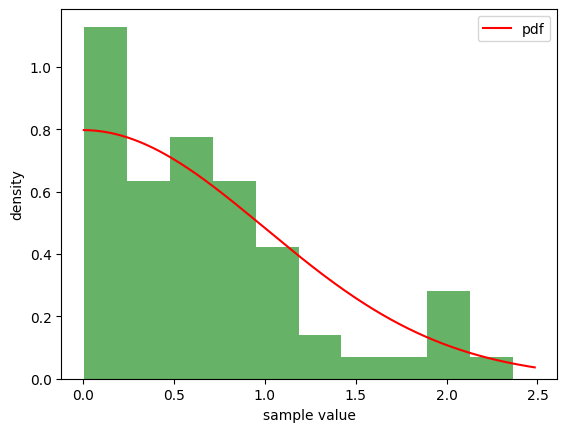

Half-normal
initial guess  [1, 0.4175410142739786, 2, 0, 1, 0]
[Algorithm 1] ECDF optimized parameters: [6.26431158e-04 5.77623154e-01 5.97391343e+00 4.41302749e-06
 2.77201502e-01 4.90953980e-03]
[Algorithm 2] MLE Optimized Parameters: [8.82175047e-04 3.66572556e+00 1.00000000e+01 1.31516694e-07
 1.32959242e-01 1.24593761e-01]
AIC:  93.43077474874727 AICc: 64.52163469453663 BIC:  105.99684212207987 EDC: 72.97313487017355 Log-Likelihood -40.715387374373634
KS : KstestResult(statistic=0.157487587976687, pvalue=0.09123946783954384, statistic_location=0.45810509632477425, statistic_sign=-1)
CVM : CramerVonMisesResult(statistic=0.45703228027529275, pvalue=0.0509528483166809)
AIC:  87.2853438569423 AICc: 58.37620380273167 BIC:  99.8514112302749 EDC: 66.82770397836859 Log-Likelihood -37.64267192847115
KS : KstestResult(statistic=0.0791229772196369, pvalue=0.8181069908441156, statistic_location=0.31215469219720154, statistic_sign=1)
CVM : CramerVonMisesResult(statistic=0.03692444968459228, pv

In [24]:
from scipy.stats import halfnorm

sample = halfnorm.rvs(size=60, loc=0.001)

fig, ax = plt.subplots(1, 1)

plt.hist(sample, bins=10, density=True, alpha=0.6, color='g')

x = np.linspace(0.95*min(sample), 1.05*max(sample), 1000)
pdf_values = halfnorm.pdf(x)

plt.plot(x, pdf_values, 'r-', label='pdf')
plt.xlabel('sample value')
plt.ylabel('density')
plt.legend()
plt.show()

optimal_params_llf, aic, aicc, bic, edc, logLik = estimate_extremeH(sample)

print(optimal_params_llf, aic, aicc, bic, edc, logLik)

In [25]:
print(sample)

[0.30197491 0.8663517  0.63243762 0.03519632 0.10125061 0.71866119
 0.57672372 2.11414076 0.09161962 0.2162635  1.03416286 1.06902735
 2.36647708 0.08144938 1.35792612 0.77401558 0.83391245 1.90489153
 0.84468819 0.18330454 0.00563777 1.09729381 0.81936663 0.49136359
 0.67836551 2.01363865 0.91589563 0.6461128  0.31215469 0.52614048
 2.08256206 0.4676986  0.16229497 0.60996946 1.86065412 0.19370145
 0.26909494 0.21689483 0.53927397 1.12953483 0.22383464 0.89312108
 0.63283943 0.72408976 0.30376026 0.124055   0.23967612 0.15162491
 1.1485307  0.30816032 0.69408383 1.43575367 0.2923842  0.62939912
 1.08743768 0.46404124 0.4581051  1.28685171 0.22939424 0.16247982]


## p-values: ks and cvm

In [28]:
ks, cvm = eval_estimated_extremeH(sample, optimal_params_llf, 4, [1, 0.4175410142739786, 2, 0, 1, 0])
# [1, 0.8190724130231952, 2, 0, 1, 0]

KS : KstestResult(statistic=0.0791229772196369, pvalue=0.8181069908441156, statistic_location=0.31215469219720154, statistic_sign=1)
CVM : CramerVonMisesResult(statistic=0.03692444968459228, pvalue=0.9496263117853657)
0 of 150 params =  [8.82175047e-04 3.66572556e+00 1.00000000e+01 1.31516694e-07
 1.32959242e-01 1.24593761e-01]
Half-normal
initial guess  [1, 0.3643974423435864, 2, 0, 1, 0]
Skipping Algorithm 1. Got a guess from user input: [1, 0.4175410142739786, 2, 0, 1, 0]
[Algorithm 2] MLE Optimized Parameters: [9.13052310e-03 9.99999990e+00 2.62799912e+00 7.86143806e-01
 4.03025876e-01 6.54805422e-01]
Partial ks:  1.0  Partial cvm:  1.0
1 of 150 params =  [8.82175047e-04 3.66572556e+00 1.00000000e+01 1.31516694e-07
 1.32959242e-01 1.24593761e-01]
Half-normal
initial guess  [1, 0.6558389167818836, 2, 0, 1, 0]
Skipping Algorithm 1. Got a guess from user input: [1, 0.4175410142739786, 2, 0, 1, 0]
[Algorithm 2] MLE Optimized Parameters: [0.36442781 1.15535029 7.97135867 1.29239071 0.15

### CI

In [ ]:
mean_optimal_params_llf, ci_optimal_params_llf, jksamples_optimal_params_llf = jackknifed_estimate_extremeH(sample, 4, [0.03468514, 0.15535166, 9.95952313, 0.01000279, 0.21149506, 0.08174569])